# Welcome to your anomaly detection tool for the PLT detector at CMS! If running this on jupyter notebook, make sure to run this first cell to ensure adtk is mounted in the correct path. Otherwise skip to cell 2 to run the function to load in the hd5 file as well as mount all necessary packages.

In [1]:
import site
import sys

user_site = site.USER_SITE
if user_site not in sys.path:
    sys.path.append(user_site)
    print(f"Added {user_site} to Python path.")
print("Updated Python path:", sys.path)

try:
    from adtk.data import validate_series
    print("adtk module imported successfully.")
except ModuleNotFoundError:
    print("ModuleNotFoundError: No module named 'adtk'")

Added /eos/user/k/kream/.local/lib/python3.9/site-packages to Python path.
Updated Python path: ['/eos/home-i01/k/kream/SWAN_projects/bril', '/cvmfs/sft.cern.ch/lcg/releases/condor/23.0.2-36b2d/x86_64-el9-gcc13-opt/lib/python3', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages/itk', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/python', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib', '', '/cvmfs/sft.cern.ch/lcg/views/LCG_105a_swan/x86_64-el9-gcc13-opt/lib/python3.9/site-packages', '/usr/local/lib/swan/nb_term_lib', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python39.zip', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9/lib-dynload', '/cvmfs/sft.cern.ch/lcg/releases/Python/3.9.12-9a1bc/x86_64-el9-gcc13-opt/lib/python3.9/site-packages', '/cv

## Load in packages.

In [2]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tables
from adtk.data import validate_series
from adtk.detector import ThresholdAD, LevelShiftAD
from datetime import datetime
import math
import warnings
import os
import scipy.optimize as opt  
from IPython.display import display_html
from IPython.core.display import display, HTML
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [3]:
happy_message = ["Gee whiskers!", "As Post Malone said - Congratulations!", "Hats off to you!", "Perfect time for a coffee break!", "Cheers, mate!", "Here's a gold star for you!", "You're doing great sweetie!", "Slay queen!",
                "Pat yourself on the back!", "We did it, we did it, we did it yay!", "Look at you go!", "Wave your hands in the air like you just don't care!", "It's a party in the USA!", "Aye yay captain!", "Skippidy doo dah day!",
                "You go girl!", "You just bopped to the top!", "Skip to my loo my darling!", "Yahtzee!", "Victory lap!", "You just passed go - collect $200!", "That's so Julia of you!"]
#because physics should be fun!

## Run the code below to load in the data table and create respective dataframes.
## For the adtk named dataframes, we define them to hold only the date-time and luminosity values to apply the anomaly detection algorithm. Make sure before running the algorithm the data is in this format, where the date-time is also the index of the dataframe. 

In [4]:
import pathlib
#list(pathlib.Path('/eos/cms/store/group/dpg_bril/comm_bril/2023/physics/').glob('*.pkl'))

In [5]:
fill_number = 8796 #change to whatever fill number you want to load in

#cleaning the hd5 file to drop any NaN values, negative luminosity values, and ensure stable beams are on
hd5 = pd.read_pickle(f'/eos/cms/store/group/dpg_bril/comm_bril/2023/physics/{fill_number}.pkl')
hd5_cleaned = hd5.dropna(how = "all")
rename_dict = {f'pltaggzero_data_{i:02}': f'pltaggzero_{i}' for i in range(16)}
pltagg_columns = [f'pltaggzero_{i}' for i in range(16)]
hd5_cleaned = hd5_cleaned.rename(columns=rename_dict)
hd5_cleaned = hd5_cleaned.loc[hd5_cleaned['beam_status'] == "STABLE BEAMS"]
hd5_cleaned = hd5_cleaned[(hd5_cleaned[pltagg_columns] >= 0).all(axis=1)]
hd5_cleaned = hd5_cleaned[(hd5_cleaned['hfetlumi_avgraw'] >= 0) & (hd5_cleaned['hfetlumi_avgraw'].notna())]
hd5_cleaned = hd5_cleaned[(hd5_cleaned['bcm1flumi_avgraw'] >= 0) & (hd5_cleaned['bcm1flumi_avgraw'].notna())]

channels = range(16)
ch_data = [hd5_cleaned[['nbnum', 'fillnum', 'runnum', 'lsnum', 'date_time', f'pltaggzero_{ch}', 'hfetlumi_avgraw', 'bcm1flumi_avgraw']].rename(columns={f'pltaggzero_{ch}': 'lumi'}) for ch in channels]

#defining the function that gives us our dataframes and finds the ratio values for a particular channel
def ch_ratio(hd5: pd.DataFrame, ch: int, ref_thr: float = 0.1) -> pd.DataFrame:
    if f'pltaggzero_{ch}' not in hd5.columns:
        print(f"Column 'pltaggzero_{ch}' does not exist.")
        return pd.DataFrame()  
    
    ch_data = hd5[hd5[f'pltaggzero_{ch}'] > 0].copy() 
    other_channels = [f'pltaggzero_{other_ch}' for other_ch in range(16) if other_ch != ch]
    ch_data['lumi_ref'] = hd5[other_channels].median(axis=1)
    ch_data = ch_data[ch_data['lumi_ref'] >= ref_thr * ch_data['lumi_ref'].mean()].reset_index(drop=True)
    ch_data['ratio'] = ch_data[f'pltaggzero_{ch}'] / ch_data['lumi_ref']
    return ch_data


#defining our dataframes
ch_ratios = [ch_ratio(hd5=hd5_cleaned, ch=ch, ref_thr=0.1) for ch in channels]
lumi_data = [ch_data[ch]['lumi'] for ch in channels]
dt_data = [ch_data[ch]['date_time'] for ch in channels]
hf_data = hd5_cleaned['hfetlumi_avgraw']
bcm1f_data = hd5_cleaned['bcm1flumi_avgraw']

df_data = pd.Series(ch_data)
df_ratio = pd.Series(ch_ratios).dropna()
df_ratio_adtk = pd.Series([ch_ratios[ch]['ratio'] for ch in channels])
df_hf = pd.Series(hf_data)
df_bcm1f = pd.Series(bcm1f_data)

lumi_df = pd.DataFrame(lumi_data).T
lumi_column_names = [f'lumi{i}' for i in channels]
lumi_df.columns = lumi_column_names

dt_df = pd.DataFrame(dt_data).T
dt_column_names = [f'date-time{i}' for i in channels]
dt_df.columns = dt_column_names

#defining the dataframes plugged into the anomaly detection algorithm later
adtk_df_ratio = pd.concat([dt_df, df_ratio_adtk], axis=1)
adtk_df = pd.concat([pd.DataFrame({f'lumi_{i}': lumi_data[i], f'date-time_{i}': dt_data[i]}) for i in channels], axis=1)

#titles for plots
titles = [f'ch{ch} lumi' for ch in channels]
titles_r = [f'ch{ch}/all' for ch in channels]

#visualize the table
hd5_cleaned

,fillnum,runnum,lsnum,nbnum,hfetlumi_avgraw,hfetlumi_avg,hfetlumi_bxraw,hfetlumi_bx,remuslumi_avgraw,remuslumi_avg,...,pltlumizero_avg,pltlumizero_bxraw,pltlumizero_bx,hfoclumi_avgraw,hfoclumi_avg,hfoclumi_bxraw,hfoclumi_bx,tcds_cmson,tcds_deadfrac,date_time
8,8796,367742,36,36,3375.585449,11122.322266,3379.833008,11136.317383,1117.030029,11184.598633,...,11084.432617,315.561401,11084.453125,974.704346,11102.142578,974.923950,11104.633789,1,0.010523,2023-05-20 03:15:42.638555648+00:00
9,8796,367742,36,40,3375.224854,11121.117188,3379.471680,11135.126953,1117.030029,11184.598633,...,11079.879883,315.422882,11079.896484,974.574463,11100.661133,974.773682,11102.921875,1,0.010583,2023-05-20 03:15:44.108659712+00:00
10,8796,367742,36,44,3375.031738,11120.491211,3379.342041,11134.699219,1124.079468,11255.183594,...,11084.809570,315.566559,11084.845703,974.411743,11098.820312,974.597656,11100.917969,1,0.010544,2023-05-20 03:15:45.578541824+00:00
11,8796,367742,36,48,3374.240723,11117.888672,3378.436035,11131.712891,1102.490356,11039.015625,...,11081.287109,315.469299,11081.291992,974.382507,11098.471680,974.566650,11100.564453,1,0.010658,2023-05-20 03:15:47.001423360+00:00
12,8796,367742,36,52,3374.035889,11117.203125,3378.155762,11130.791016,1131.129272,11325.771484,...,11083.057617,315.517731,11083.084961,974.363770,11098.247070,974.569336,11100.594727,1,0.010534,2023-05-20 03:15:48.457541376+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6657,8796,367742,452,8,0.000000,0.000000,0.470060,1.548817,3.201219,32.053162,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003792,-0.043188,1,0.000905,2023-05-20 05:57:09.840319232+00:00
6660,8796,367742,452,20,0.000000,0.000000,0.524962,1.729714,4.082413,40.876385,...,0.000384,0.000010,0.000384,0.000000,0.000000,0.004690,0.053424,1,0.000902,2023-05-20 05:57:14.229097216+00:00
6662,8796,367742,452,28,0.000000,0.000000,0.558183,1.839175,4.082413,40.876385,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.008102,-0.092281,1,0.000900,2023-05-20 05:57:17.142972160+00:00
6663,8796,367742,452,32,0.000000,0.000000,0.422376,1.391701,4.082413,40.876385,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.002210,0.025178,1,0.000910,2023-05-20 05:57:18.599729152+00:00


## Determining the reference channel for this particular fill to compare anomalies against down below. 

In [12]:
#specify any known bad channels that have failed in channels_failed
channels_failed = [6, 8, 9] 
channels_good = [ch for ch in channels if ch not in channels_failed]

#finding all luminosity values in all good channels
all_lumi_values = []
for ch in channels_good:
    all_lumi_values.extend(df_data[ch]['lumi'].values)

#finding the median value across all the good channels for each point
median_channel_series = pd.Series(all_lumi_values).median()
channel_median_diff = {}

#finding the channel whos points are the shortest distance overall from the median values across all good channels to be considered the reference channel
for ch in channels_good:
    difference_plt_median = np.abs(df_data[ch]['lumi'] - median_channel_series)
    median_diff = difference_plt_median.median()
    channel_median_diff[ch] = median_diff 

closest_channel = min(channel_median_diff, key=channel_median_diff.get)

print(f"The reference channel for fill {fill_number} is Channel {closest_channel}.")
reference = [closest_channel]

reference = ch_data[closest_channel]['lumi']
reference_dt = dt_data[closest_channel]

The reference channel for fill 8796 is Channel 4.


## Plot all channels.

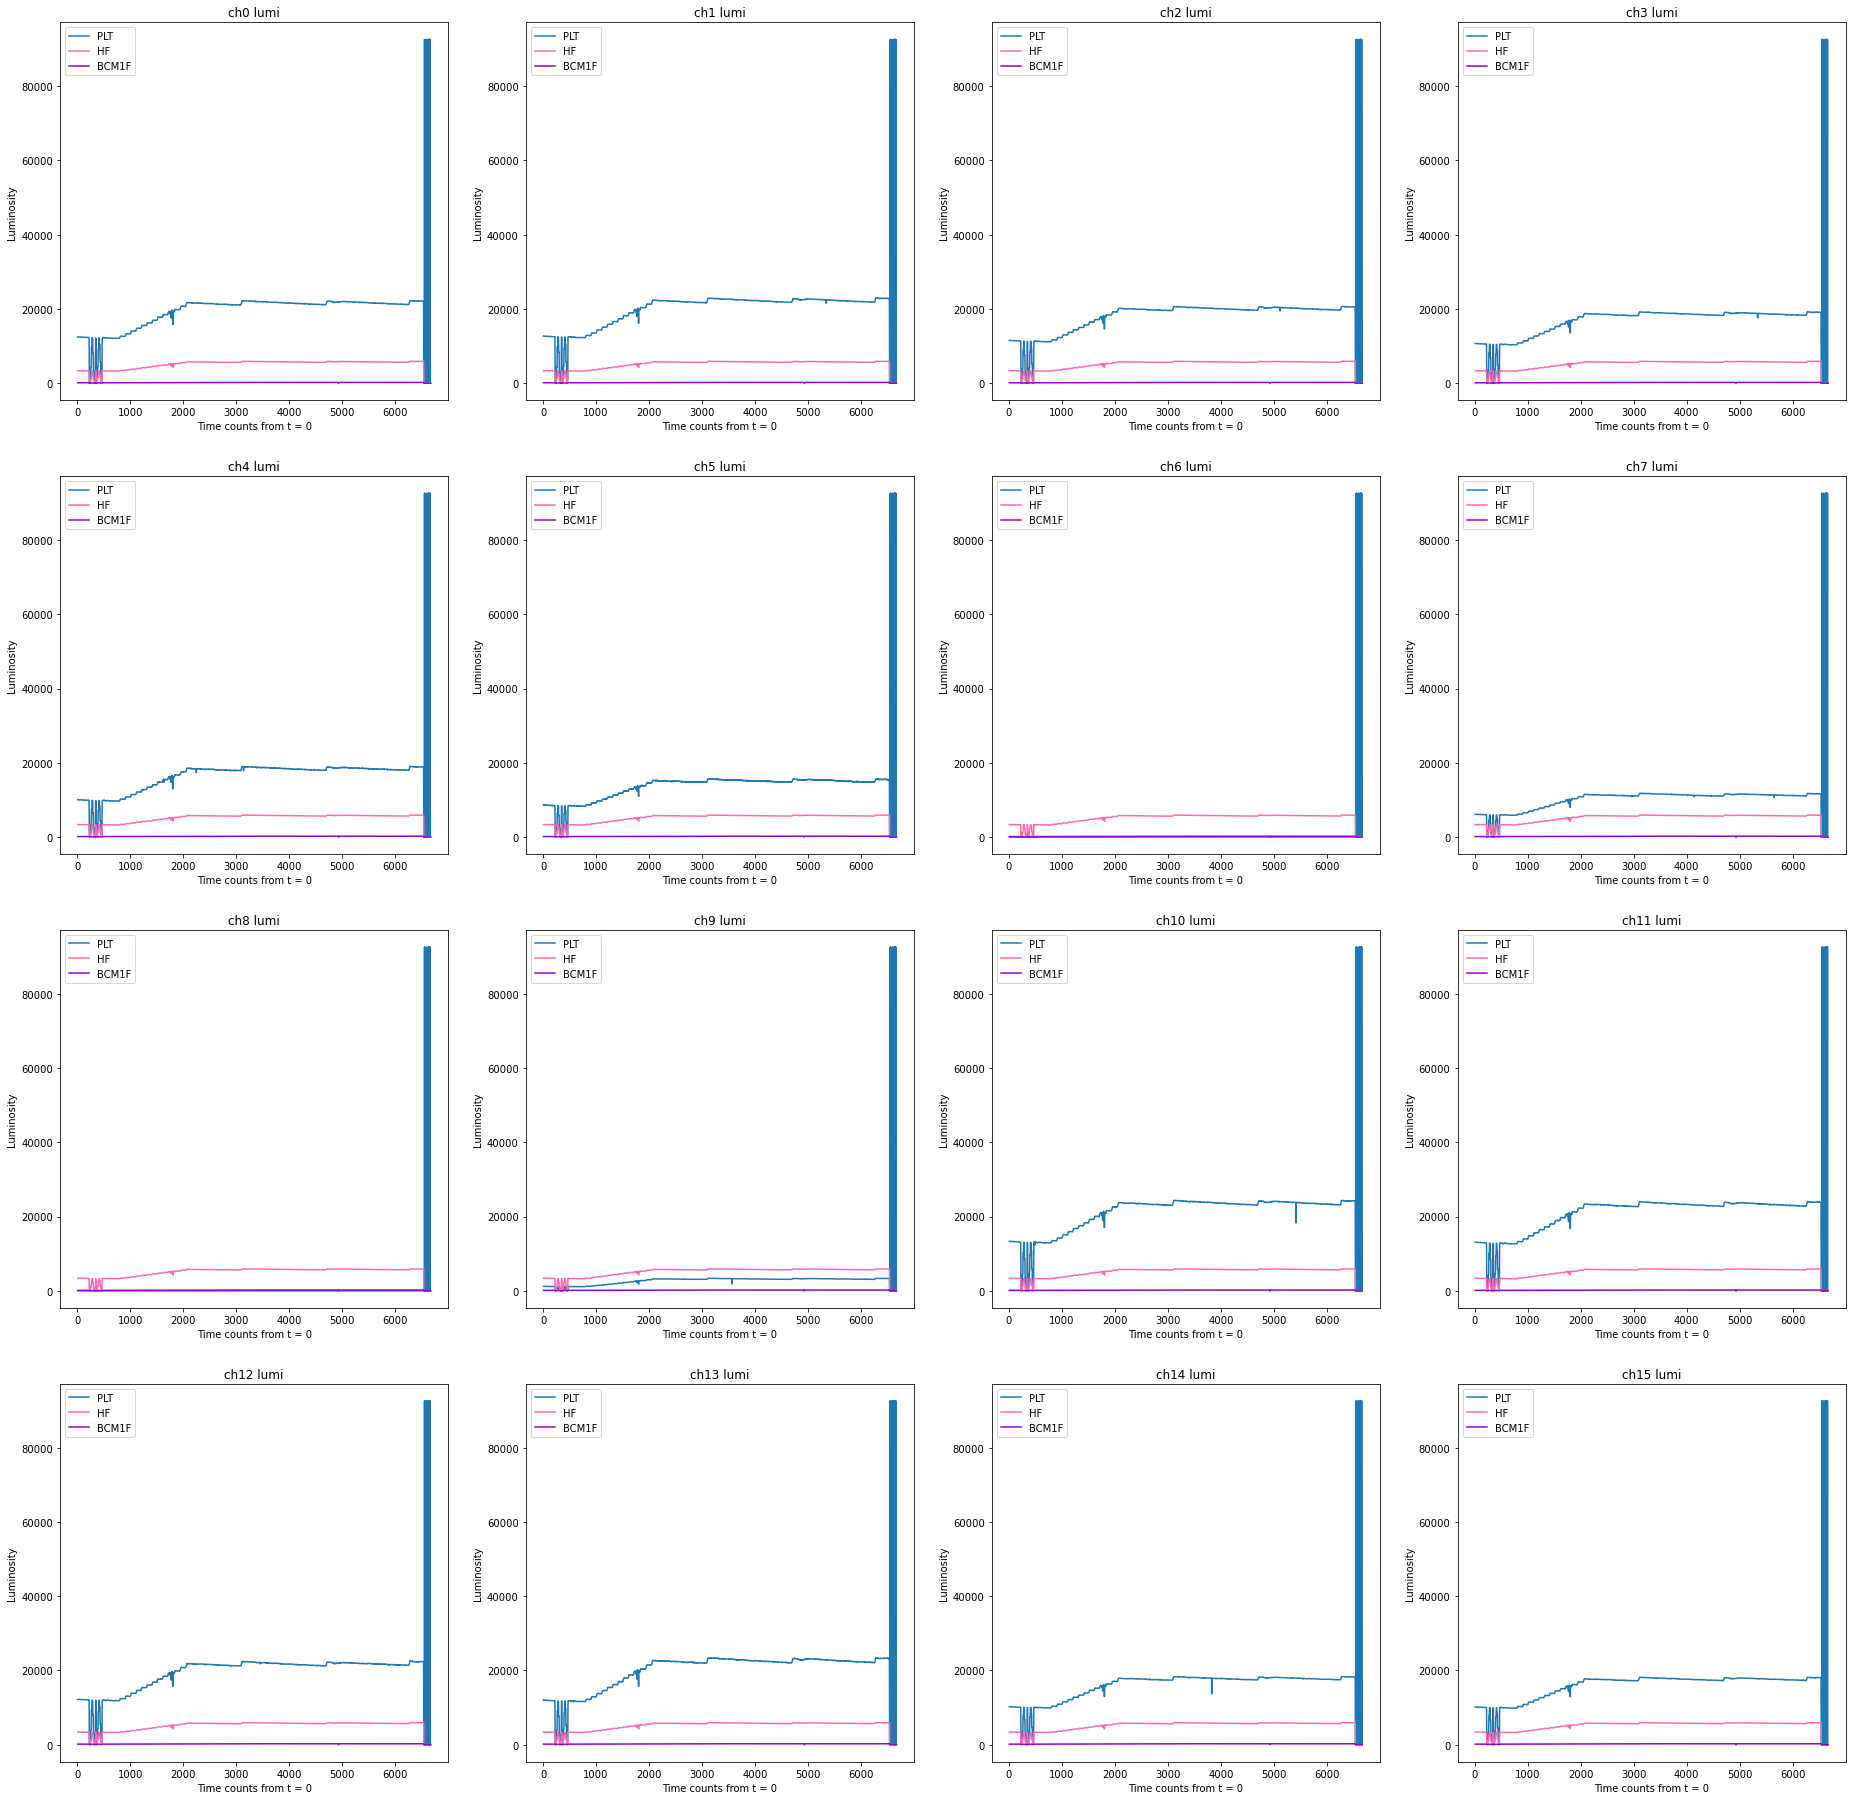

In [23]:
fig, axes = plt.subplots(4,4, figsize=(32,32))

for i, ax in enumerate(axes.flatten()):
    df_data[i].lumi.plot(ax = ax, title = titles[i], label = 'PLT')
    ax.plot(df_hf, color = 'hotpink', label = 'HF')
    ax.plot(df_bcm1f, color = 'darkviolet', label = 'BCM1F')
    ax.set_xlabel("Time counts from t = 0")
    ax.set_ylabel("Luminosity")
    #ax.set_xlim(5750,6500)
    ax.legend(loc = 'best')
    
plt.show() 

## Now plot all individual channels and all ratio channels with their respective histograms to see what the fill looks like. One thing we care about is the distribution of the ratio channel histogram for our channel selection: if the histogram shape is bad, keep it as a possibility to eliminate said channel.

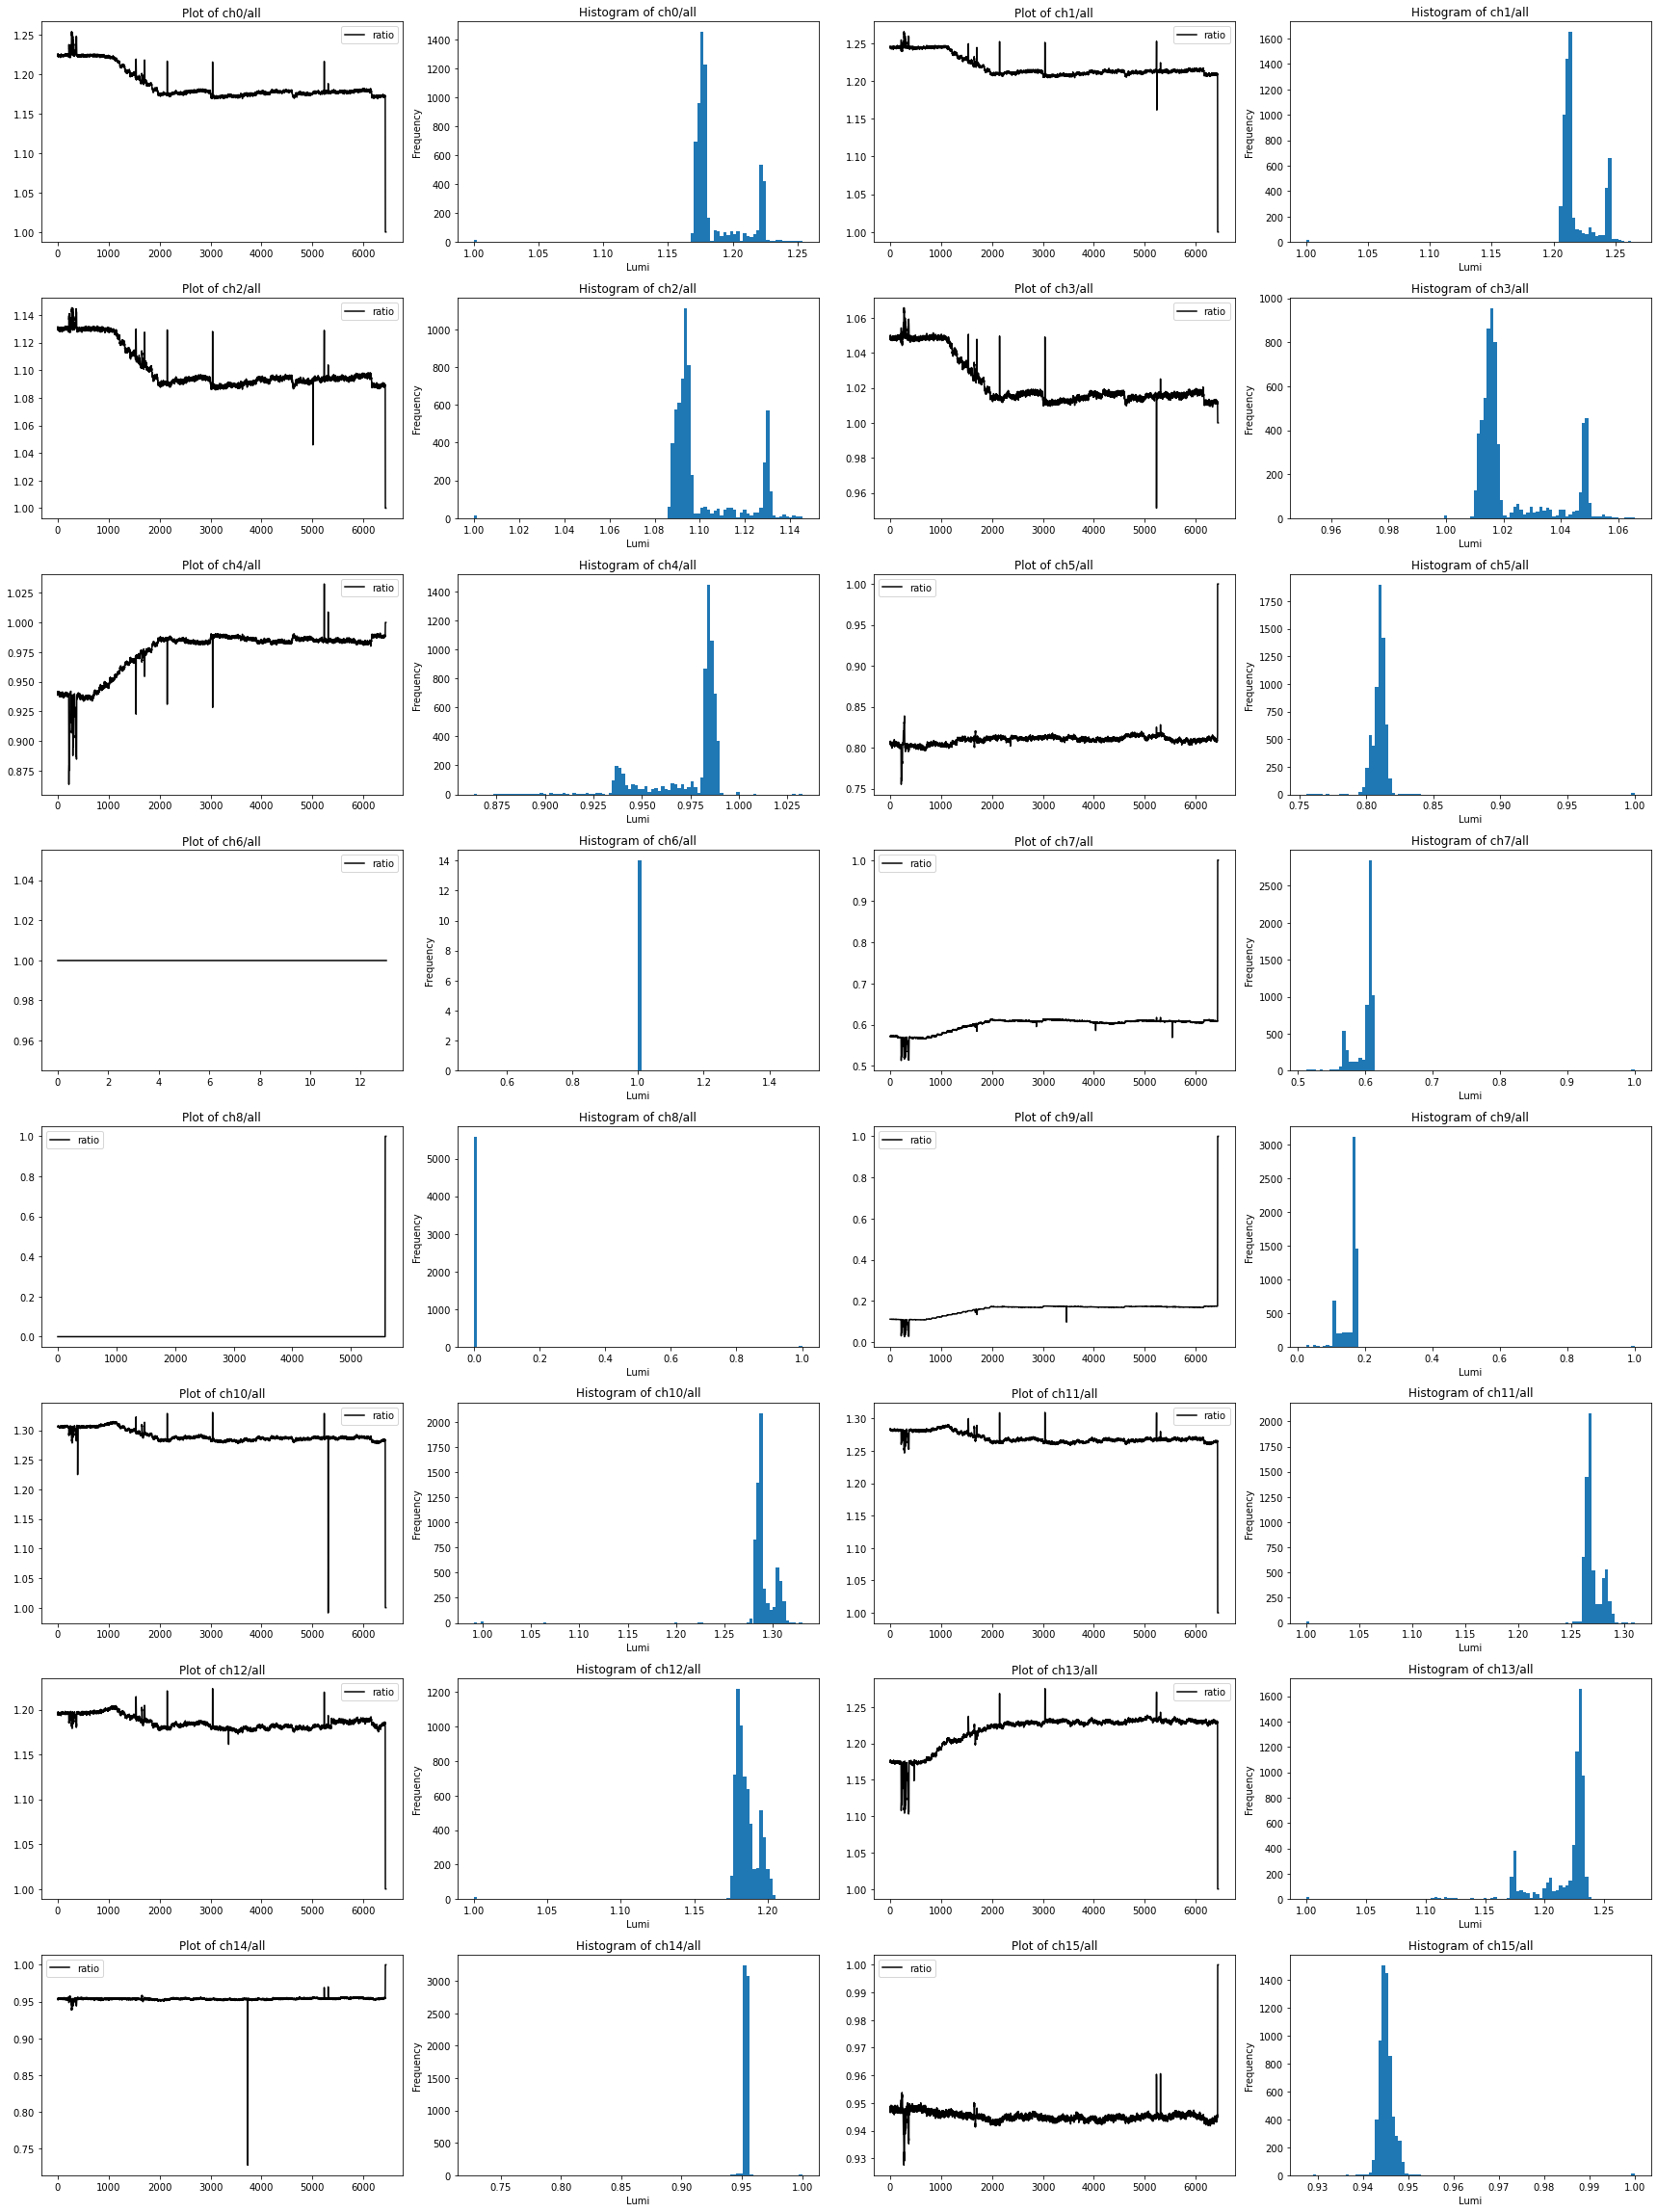

In [24]:
fig, axes = plt.subplots(8, 4, figsize=(24, 32))

for i, ax in enumerate(axes.flatten()):
    index = i // 2  
    if i % 2 == 0:
        df_ratio[index].plot(y='ratio', color='black', ax=ax)
        ax.set_title(f"Plot of {titles_r[index]}")
    else:
        valid_data = df_ratio[index]['ratio'].replace([np.inf, -np.inf], np.nan).dropna()
        
        if not valid_data.empty:
            ax.hist(valid_data, bins=100, range=(valid_data.min(), valid_data.max()))
            ax.set_title(f"Histogram of {titles_r[index]}")
            ax.set_xlabel("Lumi")
            ax.set_ylabel("Frequency")
        else:
            ax.set_title(f"Histogram of {titles_r[index]} (No valid data)")
            ax.set_xlabel("Lumi")
            ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

## Plot the ratios of plt and bcm1f as well as plt and hf to see how the shapes vary and their respective histogram distributions.

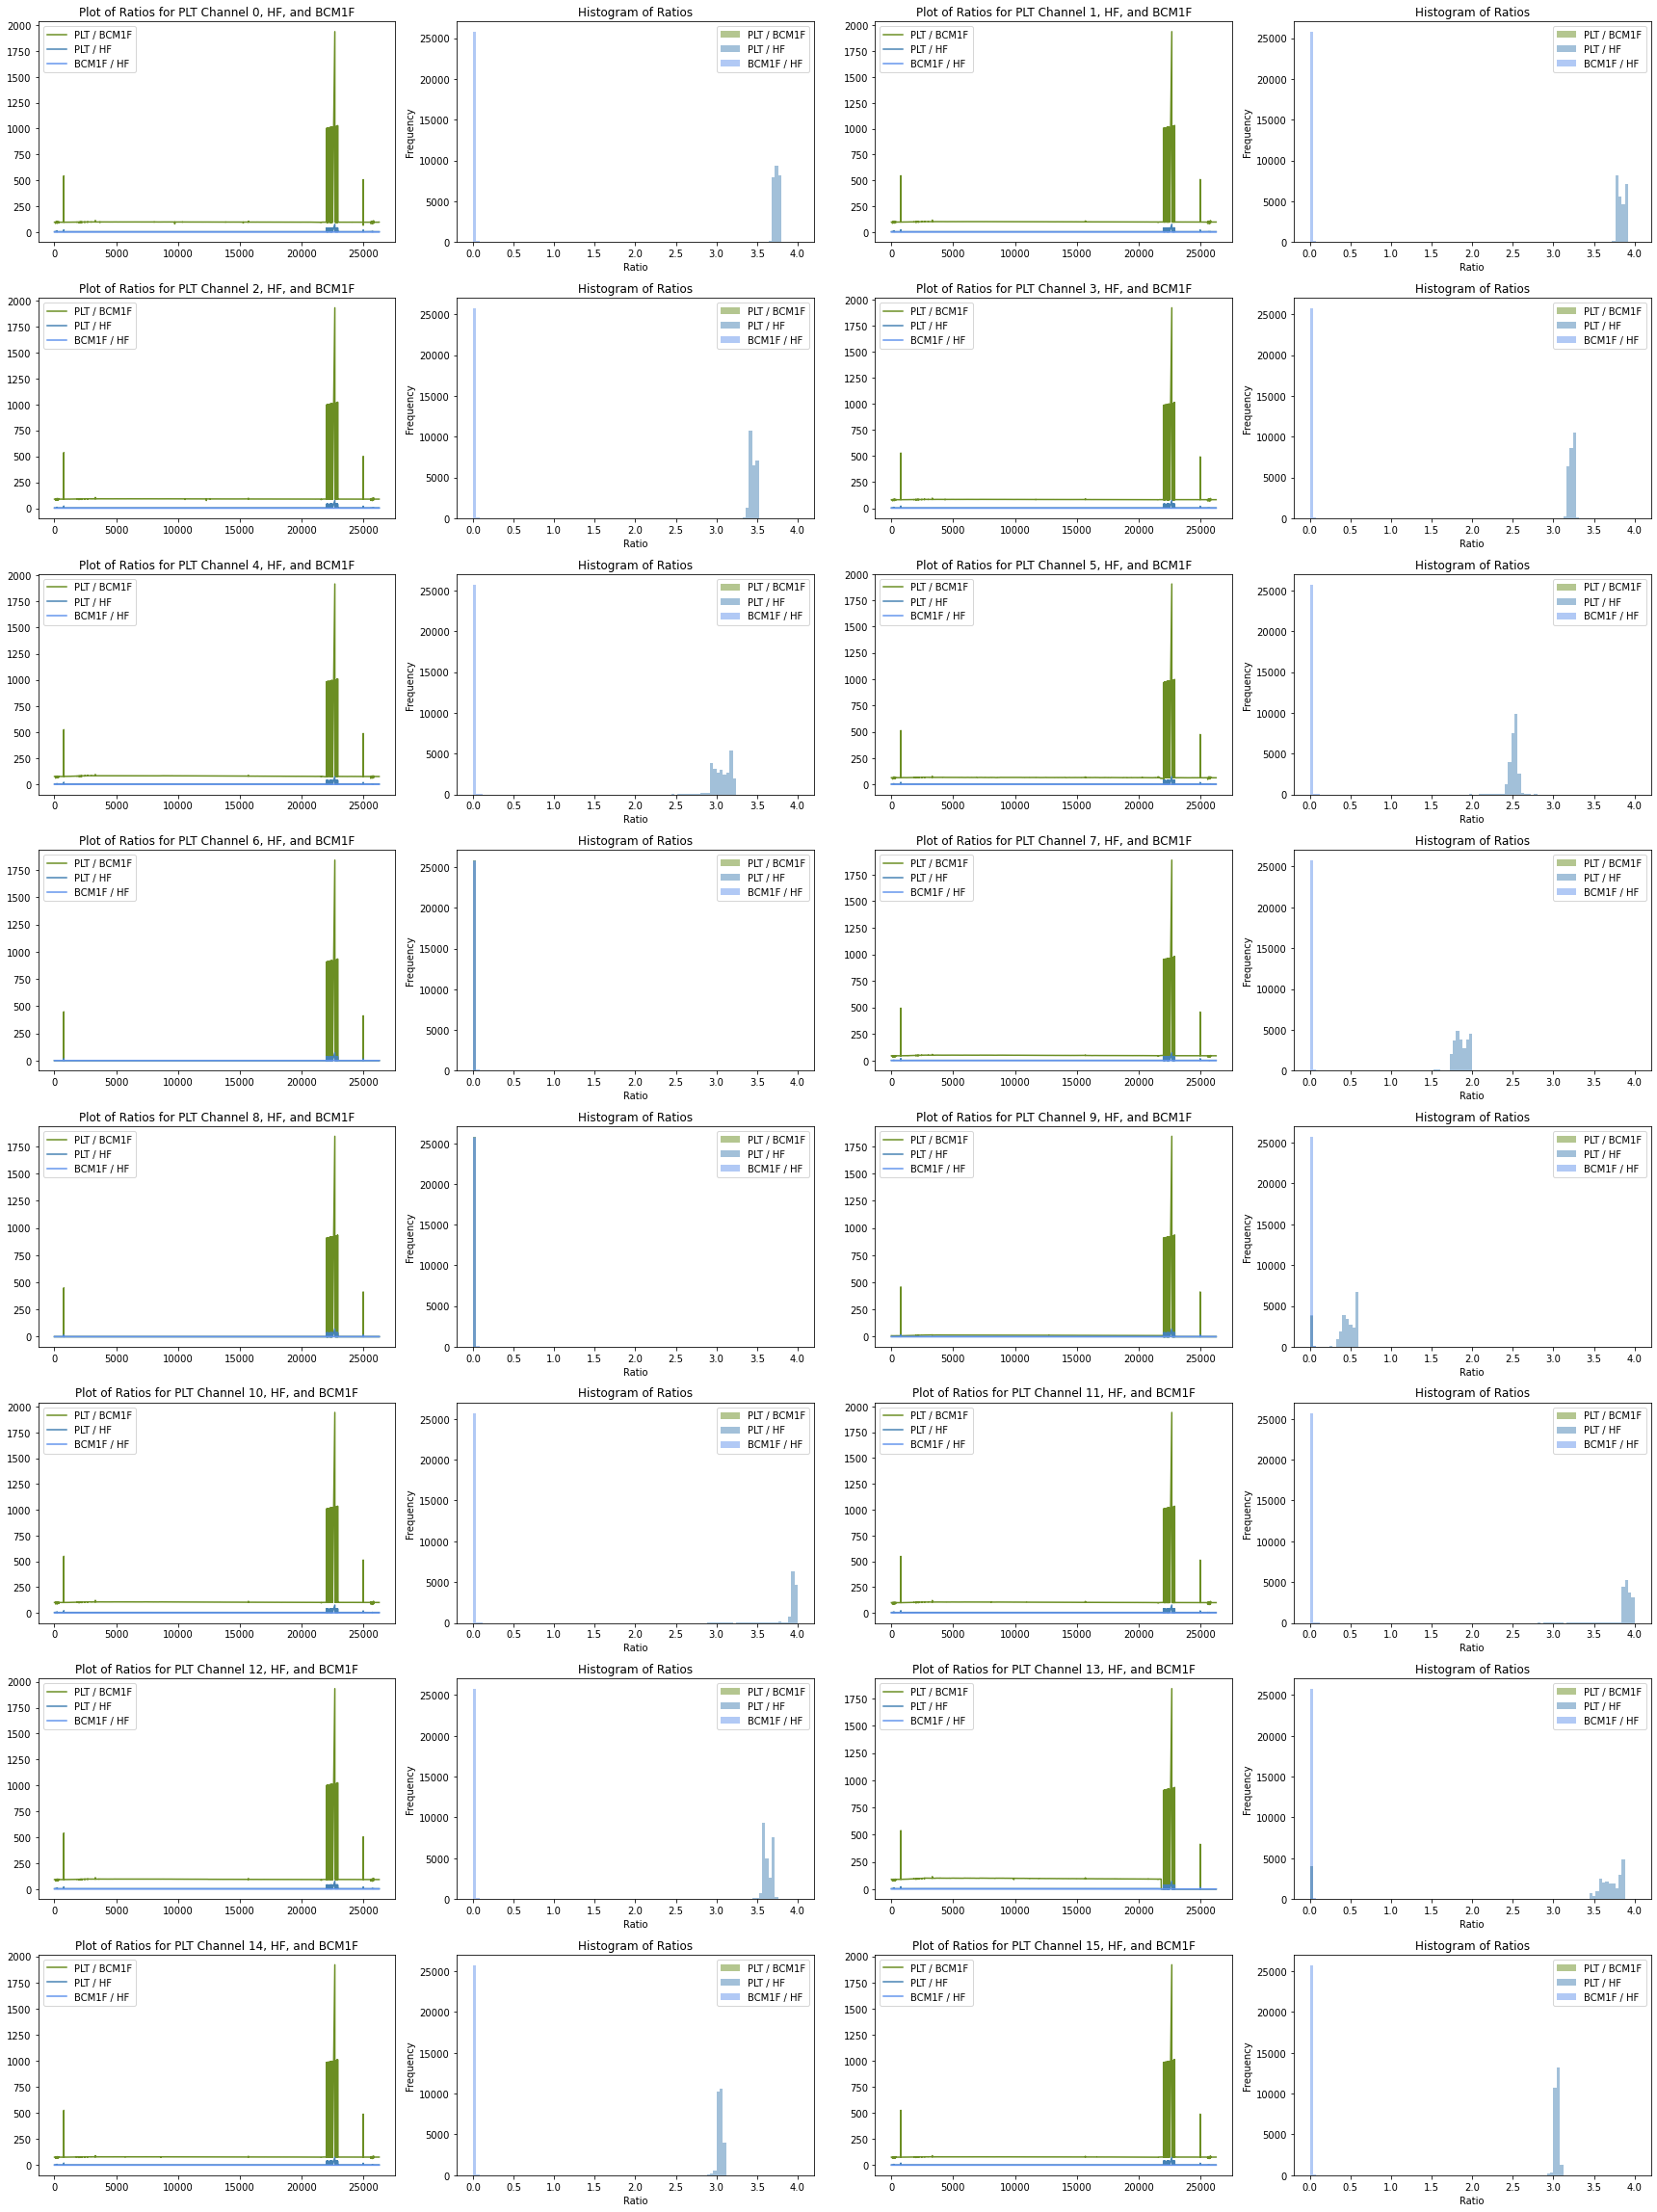

In [9]:
fig, axes = plt.subplots(8, 4, figsize=(24, 32))

for i, ax in enumerate(axes.flatten()):
    channel_index = i // 2
    
    if channel_index >= len(df_data):
        break  
    
    plt_bcm1f = df_data[channel_index].lumi / df_bcm1f
    plt_hf = df_data[channel_index].lumi / df_hf
    bcm1f_hf = df_bcm1f / df_hf
    
    if i % 2 == 0:
        ax.plot(plt_bcm1f, label='PLT / BCM1F', color='olivedrab')
        ax.plot(plt_hf, label='PLT / HF', color='steelblue')
        ax.plot(bcm1f_hf, label='BCM1F / HF', color='cornflowerblue')
        ax.set_title(f"Plot of Ratios for PLT Channel {channel_index}, HF, and BCM1F")
        ax.legend()
    else:
        ax.hist(plt_bcm1f.dropna(), bins=100, alpha=0.5, label='PLT / BCM1F', color='olivedrab', range = (0,4))
        ax.hist(plt_hf.dropna(), bins=100, alpha=0.5, label='PLT / HF', color='steelblue', range = (0,4))
        ax.hist(bcm1f_hf.dropna(), bins=100, alpha=0.5, label='BCM1F / HF', color='cornflowerblue', range = (0,4))
        ax.set_title(f"Histogram of Ratios")
        ax.set_xlabel("Ratio")
        ax.set_ylabel("Frequency")
        ax.legend()

plt.tight_layout()
plt.show()

# There are two versions of the model:
- the fully automated (function: full_automated, shows every anomaly flagged)
- the semi-automated version (function: channel_selection, performs more general channel selection) 

# To interpret what is happening in the graphs, refer to the following below:
    - The two left plots are the plotted differences between luminosity values with the reference dataframe and the individual channel being observed.
    - The two right plots are the luminosity ratios between the reference dataframe and the individual channel being observed.
    - The top two graphs show anomalies flagged from the algorithm. The bottom two plots then find the combined anomalies detected on both the difference and ratio plot and plot those flagged twice.
    

# Each anomaly plot has its own respective histogram documenting the distribution of luminosity values - these shapes should also be taken into account when choosing channels for selection.

# You can select whichever parameter values you'd like depending how intensively selection you'd prefer your model to be. To select more points, either reduce the percent, decrease levelshift, and set window to 1. For a general selection, I recommend the following: 
    - percent: 15 - 25 (we are taking values +- outside this percent window as anomalies)
    - levelshift: 300 - 600
    - window: 1 - 2
    
# Run channel_selection first to see which channels pass inspection and which ones need further inspection.

In [14]:
def round_small_vals(x):
    if np.abs(x) < 0.1:
        return 0

def clean_data(df):
    #cleaning data to drop the first 300 values if they are 0 since some fills are 0 at the beginning and this impacts teh thresholds calculated
    if isinstance(df, pd.DataFrame):
        first_vals = df.iloc[:300].applymap(round_small_vals)
        first_vals = first_vals.replace(0, np.nan)
        cleaned_df = df.copy()
        cleaned_df.iloc[:300] = first_vals 
    elif isinstance(df, pd.Series):
        first_vals = df.iloc[:300].apply(round_small_vals)
        first_vals = first_vals.replace(0, np.nan)
        cleaned_df = df.copy()
        cleaned_df.iloc[:300] = first_vals
    #dropping any infinite or NaN values
    cleaned_df.replace([np.inf, -np.inf], np.nan, inplace=True)
    cleaned_df.dropna(inplace=True)
    return cleaned_df


def detect_anomalies(df, threshold_high, threshold_low, levelshift_c_value, levelshift_window):
    #applying the adtk detectors
    df = clean_data(df)
    #validate_series is a step needed before using ThresholdAD or any other tools in adtk package
    df = validate_series(df)
    threshold_ad = ThresholdAD(high=threshold_high, low=threshold_low)
    threshold_anomalies = threshold_ad.detect(df)
    threshold_true_anomalies = threshold_anomalies[threshold_anomalies == True]
    threshold_anomaly_dates = threshold_true_anomalies.index

    level_shift_ad = LevelShiftAD(c=levelshift_c_value, window=levelshift_window)
    levelshift_anomalies = level_shift_ad.fit_detect(df)
    levelshift_true_anomalies = levelshift_anomalies[levelshift_anomalies == True]
    levelshift_anomaly_dates = levelshift_true_anomalies.index
    levelshift_anomalies_all = set(levelshift_anomaly_dates)
    
    #creating a new variable to store all anomalies detected in threshold and levelshift
    combined_anomalies = set(threshold_anomaly_dates).union(levelshift_anomalies_all)
    return combined_anomalies, threshold_anomaly_dates, levelshift_anomalies_all
    

def plot_anomalies(ax, df, combined_anomalies, threshold_anomaly_dates, levelshift_anomalies_all, channel_number, title):
    def is_scalar(val):
        return isinstance(val, (np.float64, float, int))
    
    def extract_scalar_values(anomaly_dates, anomaly_values):
        scalar_values = []
        valid_dates = []
        removed_indices = []
        
        for date, val in zip(anomaly_dates, anomaly_values):
            #removing values that aren't the right type from data
            if isinstance(val, pd.Series):
                removed_indices.append(len(scalar_values))
                continue
            if is_scalar(val):
                scalar_values.append(val)
                valid_dates.append(date)
        
        return scalar_values, valid_dates, removed_indices
    
    #verifying that the data in the anomalies detected is of the right type
    threshold_anomaly_values, threshold_anomaly_valid_dates, threshold_removed_indices = extract_scalar_values(threshold_anomaly_dates, [df.loc[idx] for idx in threshold_anomaly_dates])
    levelshift_anomaly_values, levelshift_anomaly_valid_dates, levelshift_removed_indices = extract_scalar_values(levelshift_anomalies_all, [df.loc[idx] for idx in levelshift_anomalies_all])
    combined_anomaly_values, combined_anomaly_valid_dates, combined_removed_indices = extract_scalar_values(combined_anomalies, [df.loc[idx] for idx in combined_anomalies])
    
    #creating dataframes to append the anomaly values
    threshold_anomaly_df = pd.DataFrame({'Date': threshold_anomaly_valid_dates, 'Lumi': threshold_anomaly_values})
    levelshift_anomaly_df = pd.DataFrame({'Date': levelshift_anomaly_valid_dates, 'Lumi': levelshift_anomaly_values})
    combined_anomaly_df = pd.DataFrame({'Date': combined_anomaly_valid_dates, 'Lumi': combined_anomaly_values})

    anomaly_dfs = [threshold_anomaly_df, levelshift_anomaly_df, combined_anomaly_df]
    for i, anomaly_df in enumerate(anomaly_dfs, start=0):
        anomaly_df["Date"] = pd.to_datetime(anomaly_df["Date"])
        anomaly_df.set_index("Date", inplace=True)
        
    #plotting the channel lumi data alongside the anomalies detected
    ax.plot(df.index, df, label=f"Channel {channel_number}", alpha=0.75)
    ax.scatter(threshold_anomaly_df.index, threshold_anomaly_df['Lumi'], color='darkmagenta', label='Threshold Anomalies')
    ax.scatter(levelshift_anomaly_df.index, levelshift_anomaly_df['Lumi'], color='hotpink', label='Level Shift Anomalies')
    ax.scatter(combined_anomaly_df.index, combined_anomaly_df['Lumi'], color='darkblue', label='Combined Anomalies')
    ax.set_xlabel("Date-Time")
    ax.set_ylabel("Luminosity")
    ax.grid(True)

    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f"Channel {channel_number} Anomaly Detection")

    #adding a textbox to the plot
    text_str = f"Number of Threshold Anomalies Detected: {len(threshold_anomaly_dates)}\nNumber of Level Shift Anomalies: {len(levelshift_anomalies_all)}\nTotal Anomalies: {len(combined_anomalies)}"
    bbox_props = dict(facecolor='white', alpha=0.65)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)
    

def plot_common_anomalies(ax, df, common_anomalies, channel_number, title):
    #finding the common anomalies, ie anomalies that are detected in both the difference and ratio plot with anomalies matched by repeating date-time values
    common_anomaly_values = [df.loc[idx] for idx in common_anomalies]
    common_anomalies_list = [idx.to_pydatetime() for idx in common_anomalies]
    ax.plot(df.index, df, label=f"Channel {channel_number}", alpha=0.75)
    ax.scatter(common_anomalies_list, common_anomaly_values, color='green', label='Common Anomalies')
    ax.set_xlabel("Date-Time")
    ax.set_ylabel("Luminosity")
    ax.legend()
    ax.grid(True)
    if title is not None:
        ax.set_title(title)
    else:
        ax.set_title(f"Channel {channel_number} Anomaly Detection")

    text_str = f"Number of Total Anomalies: {len(common_anomalies)}"
    bbox_props = dict(facecolor='white', alpha=0.65)
    ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

def hist_values(anomaly_values):
    #extracting minimum and maximum values from the luminosity values, while truncating a few values for channel selection so a couple outliers don't overall skew thresholds - can choose to not truncate or increase truncated values
    if len(anomaly_values) > 0:
        scalar_values = []
        for val in anomaly_values:
            if isinstance(val, pd.Series):
                continue
            if isinstance(val, (np.float64, float, int)):
                scalar_values.append(val)

        local_min_val = min(scalar_values)
        local_max_val = max(scalar_values)
        anomaly_vals_large = sorted(scalar_values, reverse=True)[:3]
        anomaly_vals_small = sorted(scalar_values)[:3]
        range_original = local_max_val - local_min_val
        
        filtered_values = [val for val in scalar_values if val not in anomaly_vals_large and val not in anomaly_vals_small]
        if filtered_values:
            filtered_values_max = max(filtered_values)
            filtered_values_min = min(filtered_values)
            range_changed = filtered_values_max - filtered_values_min
        else:
            filtered_values_max = None
            filtered_values_min = None
            
        if len(filtered_values) == 0:
            return local_min_val, local_max_val, pd.Series(dtype=float)
        
        filtered_values = pd.Series(filtered_values, dtype=float)
        return local_min_val, local_max_val, filtered_values
    else:
        return None, None, pd.Series(dtype=float)


def plot_histogram(ax, anomaly_values, channel_number, title):
    #plotting the histograms with the anomaly value distributions as well as finding the min and max anomaly values to define the ranges
    if len(anomaly_values) > 0:
        scalar_values = []
        for i, val in enumerate(anomaly_values):
            if isinstance(val, pd.Series):
                continue
            if isinstance(val, (np.float64, float, int)):
                scalar_values.append(val)
                
        min_val = min(scalar_values)
        max_val = max(scalar_values)
        ax.hist(scalar_values, bins=100, color='blue', edgecolor='black', alpha=0.7, range=(min_val, max_val))
        print(f"Channel {channel_number} - Min Value: {min_val}, Max Value: {max_val}")
        ax.set_xlabel('Luminosity')
        ax.set_ylabel('Frequency')  
        ax.set_title(title)         
        ax.grid(True) 
        print(f"the min and max values calculated here are {min_val} and {max_val}")
        
        return min_val, max_val
    else:
        print(f"Channel {channel_number} has no anomalies to plot.")
        ax.text(0.5, 0.5, "No anomalies detected", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=12)
        

def channel_selection(df1, threshold_high1, threshold_low1, levelshift_c_value, levelshift_window, channel_number,
                      df2=None, threshold_high2=None, threshold_low2=None,
                      common_anomalies=None, title1=None, title2=None, title3=None, title4=None):
    def is_infinity(value):
        return math.isinf(value) 
    
    #checking all threshold anomaly values again to ensure none of the values are NaN or infinity
    threshold_values = [(threshold_high1, threshold_low1), (threshold_high2, threshold_low2)]
    if any(is_infinity(threshold_high) or is_infinity(threshold_low) or math.isnan(threshold_high) or math.isnan(threshold_low)
           for threshold_high, threshold_low in threshold_values):
        print(f"At least one threshold value is infinity or NaN. Channel {channel_number} has failed inspection. \n")
        return
    
    #finding the different anomaly types with the set parameters that you choose when running the function 
    combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1 = detect_anomalies(df1, threshold_high1, threshold_low1, levelshift_c_value, levelshift_window)
    combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2 = detect_anomalies(df2, threshold_high2, threshold_low2, levelshift_c_value, levelshift_window)
    
    common_anomalies = combined_anomalies1.intersection(combined_anomalies2)
    num_common_anomalies = len(common_anomalies)
    print(f"Number of common anomalies in Channel {channel_number}: {num_common_anomalies}")
    
    anomaly_values1 = [df1.loc[idx] for idx in combined_anomalies1]
    anomaly_values2 = [df2.loc[idx] for idx in combined_anomalies2]
    anomaly_values3 = [df1.loc[idx] for idx in common_anomalies]
    anomaly_values4 = [df2.loc[idx] for idx in common_anomalies]
    
    min_val_1, max_val_1, filtered_vals1 = hist_values(anomaly_values1)
    min_val_2, max_val_2, filtered_vals2 = hist_values(anomaly_values2)
    min_val_3, max_val_3, filtered_vals3 = hist_values(anomaly_values3)
    min_val_4, max_val_4, filtered_vals4 = hist_values(anomaly_values4)
    
    #finding the actual ranges and truncated ranges
    difference1 = max_val_1 - min_val_1 if max_val_1 is not None and min_val_1 is not None else None
    difference2 = max_val_2 - min_val_2 if max_val_2 is not None and min_val_2 is not None else None
    difference3 = filtered_vals3.max() - filtered_vals3.min() if filtered_vals3 is not None else None
    difference4 = filtered_vals4.max() - filtered_vals4.min() if filtered_vals4 is not None else None
    
    
    print(f"Difference1: {difference1}, Difference2: {difference2}; Difference3: {difference3}, Difference4: {difference4}")
    
    #dealing with different scenarios for luminosity distribution since the ranges can vary quite drastically
    if difference1 is not None and difference1 > 2000:
        if num_common_anomalies >= 100:
            if (difference3 is not None and difference3 > 400) or (difference4 is not None and difference4 > 0.75):
                print(f"Channel {channel_number} has failed inspection. \nThe width of the difference histogram is {difference3}. \nThe width of the ratio histogram is {difference4}. Inspect further to determine validity.\n")
            else:
                print(f"Channel {channel_number} has passed inspection.\n")
        else:
            print(f"Channel {channel_number} has passed inspection.\n")
    else:
        if num_common_anomalies >= 50:
            if (difference3 is not None and difference3 > 50) or (difference4 is not None and difference4 > 0.35):
                print(f"Channel {channel_number} has failed inspection. \nThe width of the difference histogram is {difference3}. \nThe width of the ratio histogram is {difference4}. Inspect further to determine validity.\n")
            else:
                print(f"Channel {channel_number} has passed inspection.\n")
        else:
            print(f"Channel {channel_number} has passed inspection.\n")

# Begin Channel Selection 

In [15]:
#defining the reference channel based on code from earlier
reference = ch_data[closest_channel]['lumi']
reference_dt = dt_data[closest_channel]

#defining the parameters for the channel selection tool
percent = 0.20
levelshift = 300
window = 2


for channel in channels:
    if channel in channels_failed:
        print(f"Skipping bad channel {channel}. \n")
        continue 
    
    select_channel = channel
    #checking to ensure the lengths match
    if not (len(reference) == len(ch_data[select_channel]['lumi']) == len(reference - ch_data[select_channel]['lumi'])):
        print(f"There is an issue with the lengths for channel {select_channel}") 
        print(f"Length of reference: {len(reference)}")
        print(f"Length of select_channel: {len(ch_data[select_channel]['lumi'])}")
        print(f"Length of channels subtracted: {len(reference - ch_data[select_channel]['lumi'])}")
        continue 

    ch_data[select_channel]['lumi'].replace([np.inf, -np.inf], np.nan, inplace=True)
    ch_data[select_channel]['lumi'].dropna(inplace=True)

    #finding the difference between reference and select channel
    difference = reference - ch_data[select_channel]['lumi']
    difference.index = reference_dt
    difference.index = pd.to_datetime(difference.index).floor('s')

    #finding the ratio between reference and select channel
    ratio = (reference / ch_data[select_channel]['lumi'])
    ratio.index = reference_dt
    ratio.index = pd.to_datetime(ratio.index).floor('s')
    ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()
    
    #finding mean values for difference and ratio across all points
    differencemean = np.mean(difference)
    ratiomean = np.mean(ratio)

    threshold_high2 = ratiomean + percent * ratiomean
    threshold_low2 = ratiomean - percent * ratiomean
    
    #dealing with different scenarios if the difference mean is negative or positive 
    if differencemean < 0:
        threshold_high1_diff = differencemean - percent * differencemean
        threshold_low1_diff = differencemean + percent * differencemean
    else:
        threshold_high1_diff = differencemean + percent * differencemean
        threshold_low1_diff = differencemean - percent * differencemean

    try:
        #run channel selection
        channel_selection(difference, threshold_high1=threshold_high1_diff, threshold_low1=threshold_low1_diff, levelshift_c_value=levelshift, levelshift_window=window, channel_number=select_channel,
                          df2=ratio, threshold_high2=threshold_high2, threshold_low2=threshold_low2, 
                          title1=f"Reference - {select_channel} Anomaly Detection, Percent = +- {percent * 100}%", title2=f"Reference/{select_channel} Ratio Anomaly Detection, Percent = +- {percent * 100}%",
                          title3=f"Reference - {select_channel} Common Anomaly Detection, Percent = +- {percent * 100}%", title4=f"Reference / {select_channel} Ratio Common Anomaly Detection, Percent = +- {percent * 100}%")
    except Exception as e:
        print(f"Channel {select_channel} failed inspection with error: {e}. \n")

        
print(f"{np.random.choice(happy_message)} You just verified fill number {fill_number}.")

Number of common anomalies in Channel 0: 11
Difference1: 4405.0846716177, Difference2: 1.0; Difference3: nan, Difference4: 0.15000000000000002
Channel 0 has passed inspection.

Number of common anomalies in Channel 1: 23
Difference1: 5074.0993846714955, Difference2: 1.0; Difference3: nan, Difference4: 0.16666666666666669
Channel 1 has passed inspection.

Number of common anomalies in Channel 2: 9
Difference1: 2819.6331184247756, Difference2: 1.0; Difference3: 0.0, Difference4: 0.0
Channel 2 has passed inspection.

Number of common anomalies in Channel 3: 5
Difference1: 2276.8921543059587, Difference2: 1.0; Difference3: nan, Difference4: nan
Channel 3 has passed inspection.

Number of common anomalies in Channel 4: 0
Difference1: None, Difference2: None; Difference3: nan, Difference4: nan
Channel 4 has passed inspection.

Number of common anomalies in Channel 5: 12
Difference1: 3483.670464864272, Difference2: 2.0; Difference3: 0.002287870927760881, Difference4: 0.7499999505833403
Channe

# Run this code if a channel has failed selection.

Number of common anomalies in Channel 13: 22188


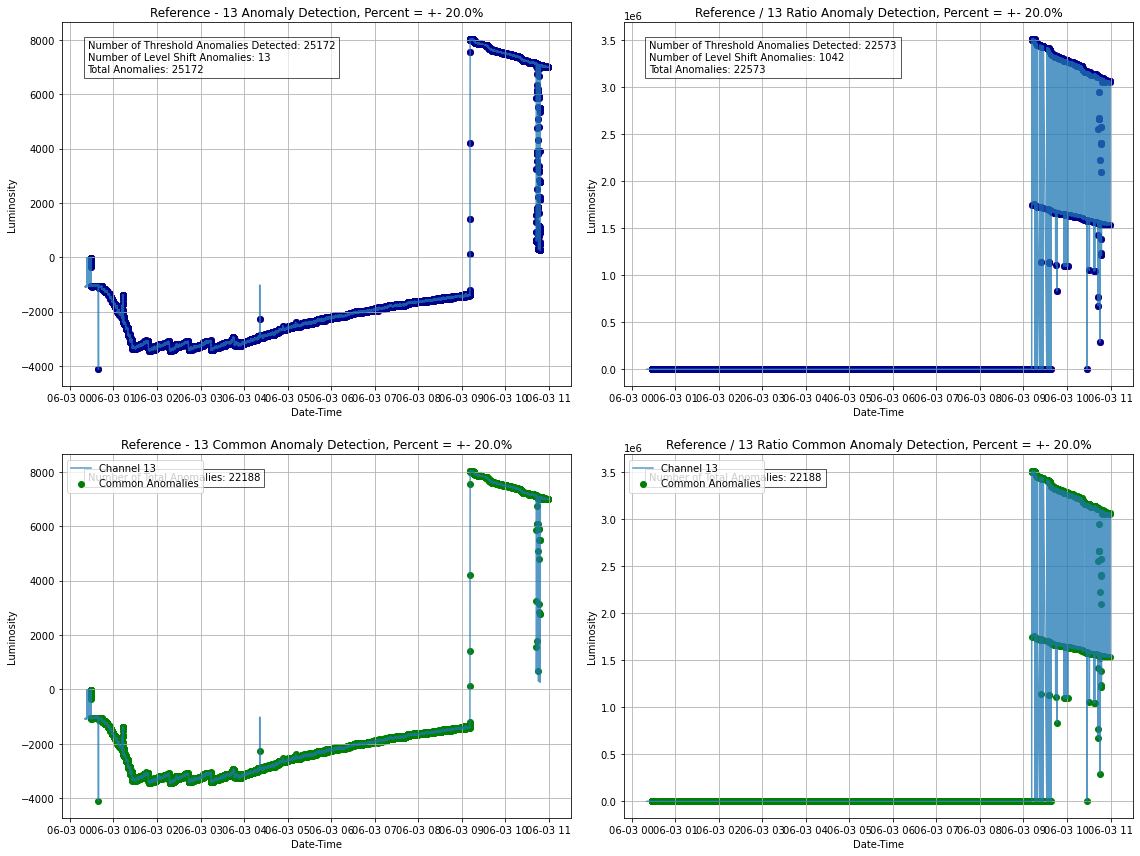

Channel 13 - Min Value: -4117.811022805312, Max Value: 8032.309365615843
the min and max values calculated here are -4117.811022805312 and 8032.309365615843
Channel 13 - Min Value: 0.793371558407982, Max Value: 3509454.6325366586
the min and max values calculated here are 0.793371558407982 and 3509454.6325366586
Channel 13 - Min Value: -4117.811022805312, Max Value: 8029.17693820544
the min and max values calculated here are -4117.811022805312 and 8029.17693820544
Channel 13 - Min Value: 0.793371558407982, Max Value: 3509454.6325366586
the min and max values calculated here are 0.793371558407982 and 3509454.6325366586


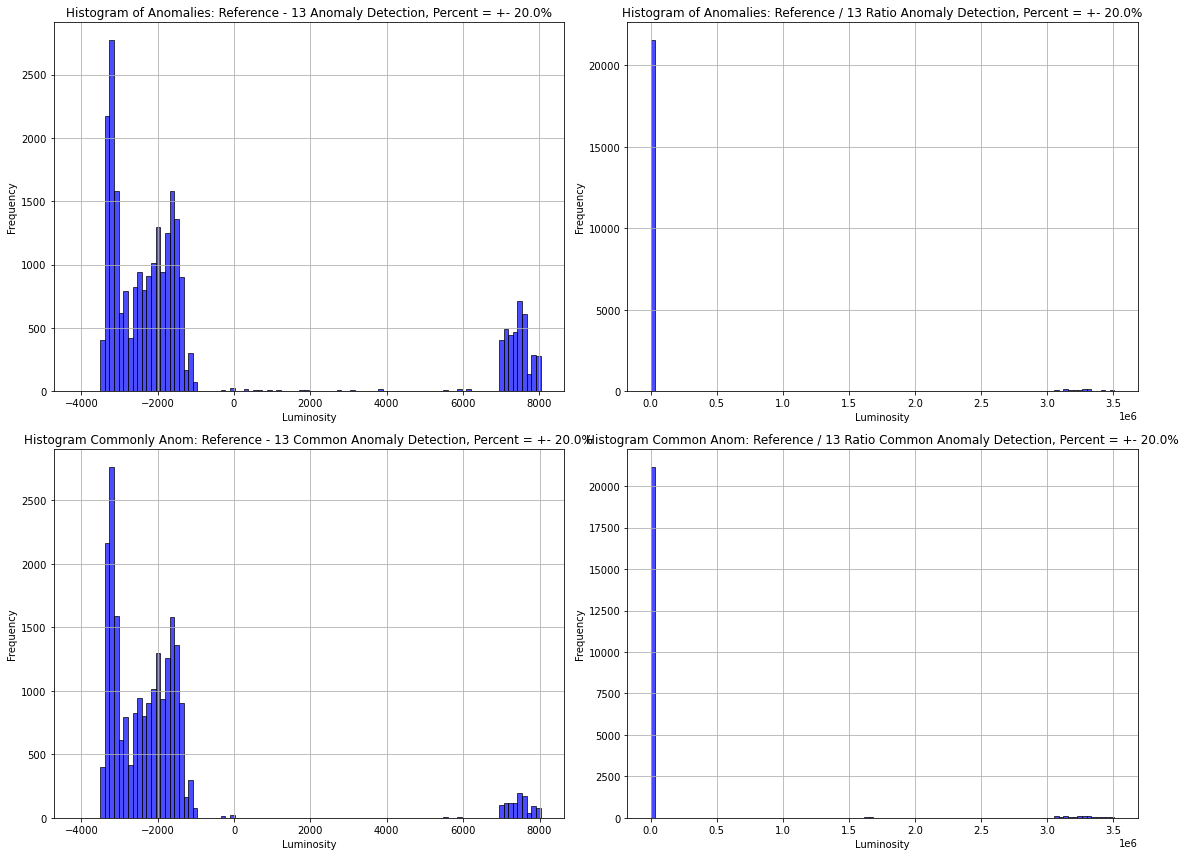

In [13]:
def full_automated(df1, threshold_high1, threshold_low1, levelshift_c_values, levelshift_windows, channel_number, df2=None, 
                   threshold_high2=None, threshold_low2=None, common_anomalies=None, title1=None, title2=None, title3=None, title4=None, show_histograms = False):
    
    #creating subplots to visualize issues in failed channels
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    #plotting the anomalies for respective plots
    combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1 = detect_anomalies(df1, threshold_high1, threshold_low1, levelshift_c_values, levelshift_windows)
    plot_anomalies(axs[0, 0], df1, combined_anomalies1, threshold_anomaly_dates1, levelshift_anomalies_all1, channel_number, title1)
    
    combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2 = detect_anomalies(df2, threshold_high2, threshold_low2, levelshift_c_values, levelshift_windows)
    plot_anomalies(axs[0, 1], df2, combined_anomalies2, threshold_anomaly_dates2, levelshift_anomalies_all2, channel_number, title2)
    
    common_anomalies = combined_anomalies1.intersection(combined_anomalies2)
    num_common_anomalies = len(common_anomalies)
    print(f"Number of common anomalies in Channel {channel_number}: {num_common_anomalies}")

    #plotting the common anomalies across the two earlier plots
    plot_common_anomalies(axs[1,0], df1, common_anomalies, channel_number, title3)
    plot_common_anomalies(axs[1,1], df2, common_anomalies, channel_number, title4)
    plt.tight_layout()
    plt.show()
    
    if show_histograms:
        #showing the histogram distributions of the anomalies
        fig, hist_axes = plt.subplots(2, 2, figsize=(16, 12))

        anomaly_values1 = [df1.loc[idx] for idx in combined_anomalies1]
        plot_histogram(hist_axes[0, 0], anomaly_values1, channel_number, f"Histogram of Anomalies: {title1 if title1 else f'Channel {channel_number}'}")

        anomaly_values2 = [df2.loc[idx] for idx in combined_anomalies2]
        plot_histogram(hist_axes[0, 1], anomaly_values2, channel_number, f"Histogram of Anomalies: {title2 if title2 else f'Channel {channel_number}'}")

        anomaly_values3 = [df1.loc[idx] for idx in common_anomalies]
        plot_histogram(hist_axes[1, 0], anomaly_values3, channel_number, f"Histogram Commonly Anom: {title3 if title3 else f'Channel {channel_number}'}")
        
        anomaly_values4 = [df2.loc[idx] for idx in common_anomalies]
        plot_histogram(hist_axes[1, 1], anomaly_values4, channel_number, f"Histogram Common Anom: {title4 if title4 else f'Channel {channel_number}'}")
        
        plt.tight_layout()
        plt.show()
        
#choose the channel you want to inspect further
select_channel = 13
difference = reference - ch_data[select_channel]['lumi']
difference.index = reference_dt
difference.index = pd.to_datetime(difference.index).floor('s')

ratio = reference / ch_data[select_channel]['lumi']
ratio.index = reference_dt
ratio.index = pd.to_datetime(ratio.index).floor('s')
ratio = ratio.replace([np.inf, -np.inf], np.nan).dropna()

differencemean = np.mean(difference)
ratiomean = np.mean(ratio)

threshold_high2_ratio = ratiomean + percent * ratiomean
threshold_low2_ratio = ratiomean - percent * ratiomean

if differencemean < 0:
    threshold_high1_diff = differencemean - percent * differencemean
    threshold_low1_diff = differencemean + percent * differencemean
else:
    threshold_high1_diff = differencemean + percent * differencemean
    threshold_low1_diff = differencemean - percent * differencemean

    
#run the algorithm
full_automated(difference, threshold_high1=threshold_high1_diff, threshold_low1=threshold_low1_diff, levelshift_c_values=levelshift, levelshift_windows=window, channel_number= select_channel,
                           df2=ratio, threshold_high2=threshold_high2_ratio, threshold_low2=threshold_low2_ratio, 
                           title1=f"Reference - {select_channel} Anomaly Detection, Percent = +- {percent * 100}%", title2=f"Reference / {select_channel} Ratio Anomaly Detection, Percent = +- {percent * 100}%",
                           title3=f"Reference - {select_channel} Common Anomaly Detection, Percent = +- {percent * 100}%", title4=f"Reference / {select_channel} Ratio Common Anomaly Detection, Percent = +- {percent * 100}%", 
                           show_histograms = True)

# Run this code below to append the data to csv files and to visualize PLT data trends for all previously inspected runs.

In [7]:
processed_fills = []  
hist_year_data = {f"hist_year_data_{ch}": [] for ch in channels} 
dt_data_channel = dt_data[0]
csv_folder = "plt_channel_data"     

#creating a folder to store this data for easier access and organization
if not os.path.exists(csv_folder):
    os.makedirs(csv_folder)       

def process_fill(fill_number, df_ratio, titles_r):
    
    combined_hist_data = None  
    
    for i in range(len(channels)):
        channel = channels[i]
        if channel in channels_failed:
            continue 
        
        #finding the median date-time value to append that as the date-time value for that fill so we can plot the time for that fill in the histogram below and have the entire fill be plotted for that specific time
        median_dt_index = np.round(len(dt_data_channel) / 2).astype(int) 
        median_dt_time = dt_data_channel.iloc[median_dt_index]
        
        valid_data = df_ratio[channel]['ratio'].replace([np.inf, -np.inf], np.nan).dropna()
        common_indices = valid_data.index.intersection(dt_data[channel].index)
        valid_data_dt = dt_data[channel].loc[common_indices]
        
        hist_data, bin_edges = np.histogram(valid_data, bins=100, range=(valid_data.min(), valid_data.max()))
        hist_year_data[f"hist_year_data_{channel}"].append((hist_data, bin_edges))
    
    for channel in channels:
        if channel in channels_failed:
            continue  
    
        hist_data_list = hist_year_data[f"hist_year_data_{channel}"]
        all_hist_data = []
        
        #creating dataframe of all info 
        for hist_data, bin_edges in hist_data_list:
            for bin_edge, count in zip(bin_edges, hist_data):
                all_hist_data.append({'Bin_Edges': bin_edge, 'Count': count, 'Fill_Number': fill_number, 'Date-Time': median_dt_time})
        
        new_hist_data = pd.DataFrame(all_hist_data)
        channel_filename = os.path.join(csv_folder, f"hist_data_channel_{channel}.csv")
        
        if os.path.exists(channel_filename):
            existing_hist_data = pd.read_csv(channel_filename)
            #checking if the fill has been previously processed to avoid adding it multiple times
            if 'Fill_Number' in existing_hist_data.columns and (existing_hist_data['Fill_Number'] == fill_number).any():
                print(f"Data for fill number {fill_number} in channel {channel} has previously been processed.")
                continue
    
            #if it is new, then concatinating all columns created above and appending to the csv later
            combined_hist_data = pd.concat([existing_hist_data, new_hist_data])
            numeric_cols = combined_hist_data.select_dtypes(include=np.number).columns
            non_numeric_cols = combined_hist_data.select_dtypes(exclude=np.number).columns
            grouped_data = combined_hist_data.groupby('Bin_Edges', as_index=False)[numeric_cols].sum()
            
            #have to treat Date-time column separate because it is different type
            if 'Date-Time' in non_numeric_cols:
                non_numeric_data = combined_hist_data[['Bin_Edges', 'Date-Time']].drop_duplicates()
                combined_hist_data = pd.merge(grouped_data, non_numeric_data, on='Bin_Edges', how='left')
            
            print(f"Fill number {fill_number} for channel {channel} has now been processed and appended to other 2023 data.")
        else:
            combined_hist_data = new_hist_data
        
        combined_hist_data.to_csv(channel_filename, index=False)
    
    #treating the bcm1f csv
    bcm1f_filename = "bcm1f_data.csv"
    if os.path.exists(bcm1f_filename):
        existing_bcm1f_data = pd.read_csv(bcm1f_filename)
        
        if 'Fill_Number' in existing_bcm1f_data.columns and (existing_bcm1f_data['Fill_Number'] == fill_number).any():
            print(f"Data for fill number {fill_number} in bcm1f_data has previously been processed.")
        else:
            bcm1f_data_to_append = pd.DataFrame(all_hist_data)
            bcm1f_data_to_append['Fill_Number'] = fill_number
            combined_bcm1f_data = pd.concat([existing_bcm1f_data, bcm1f_data_to_append])
            combined_bcm1f_data.to_csv(bcm1f_filename, index=False)
            print(f"Fill number {fill_number} has now been processed and appended to bcm1f_data.")
    else:
        new_hist_data['Fill_Number'] = fill_number
        new_hist_data.to_csv(bcm1f_filename, index=False)
        print(f"Fill number {fill_number} data saved to bcm1f_data.csv.")
    
    #treating the hf csv
    hf_filename = "hf_data.csv"
    if os.path.exists(hf_filename):
        existing_hf_data = pd.read_csv(hf_filename)
        
        if 'Fill_Number' in existing_hf_data.columns and (existing_hf_data['Fill_Number'] == fill_number).any():
            print(f"Data for fill number {fill_number} in hf_data has previously been processed.")
        else:
            hf_data_to_append = pd.DataFrame(all_hist_data) 
            hf_data_to_append['Fill_Number'] = fill_number
            combined_hf_data = pd.concat([existing_hf_data, hf_data_to_append])
            combined_hf_data.to_csv(hf_filename, index=False)
            print(f"Fill number {fill_number} has now been processed and appended to hf_data.")
    else:
        new_hist_data['Fill_Number'] = fill_number
        new_hist_data.to_csv(hf_filename, index=False)
        print(f"Fill number {fill_number} data saved to hf_data.csv.")
    processed_fills.append(fill_number)
    return combined_hist_data

#running the appending process
result = process_fill(fill_number, df_ratio, titles_r)

Data for fill number 8796 in channel 0 has previously been processed.
Data for fill number 8796 in channel 1 has previously been processed.
Data for fill number 8796 in channel 2 has previously been processed.
Data for fill number 8796 in channel 3 has previously been processed.
Data for fill number 8796 in channel 4 has previously been processed.
Data for fill number 8796 in channel 5 has previously been processed.
Data for fill number 8796 in channel 7 has previously been processed.
Data for fill number 8796 in channel 10 has previously been processed.
Data for fill number 8796 in channel 11 has previously been processed.
Data for fill number 8796 in channel 12 has previously been processed.
Data for fill number 8796 in channel 13 has previously been processed.
Data for fill number 8796 in channel 14 has previously been processed.
Data for fill number 8796 in channel 15 has previously been processed.
Data for fill number 8796 in bcm1f_data has previously been processed.
Data for fill

# Display histograms for all fills studied to see how PLT data has shifted overtime.

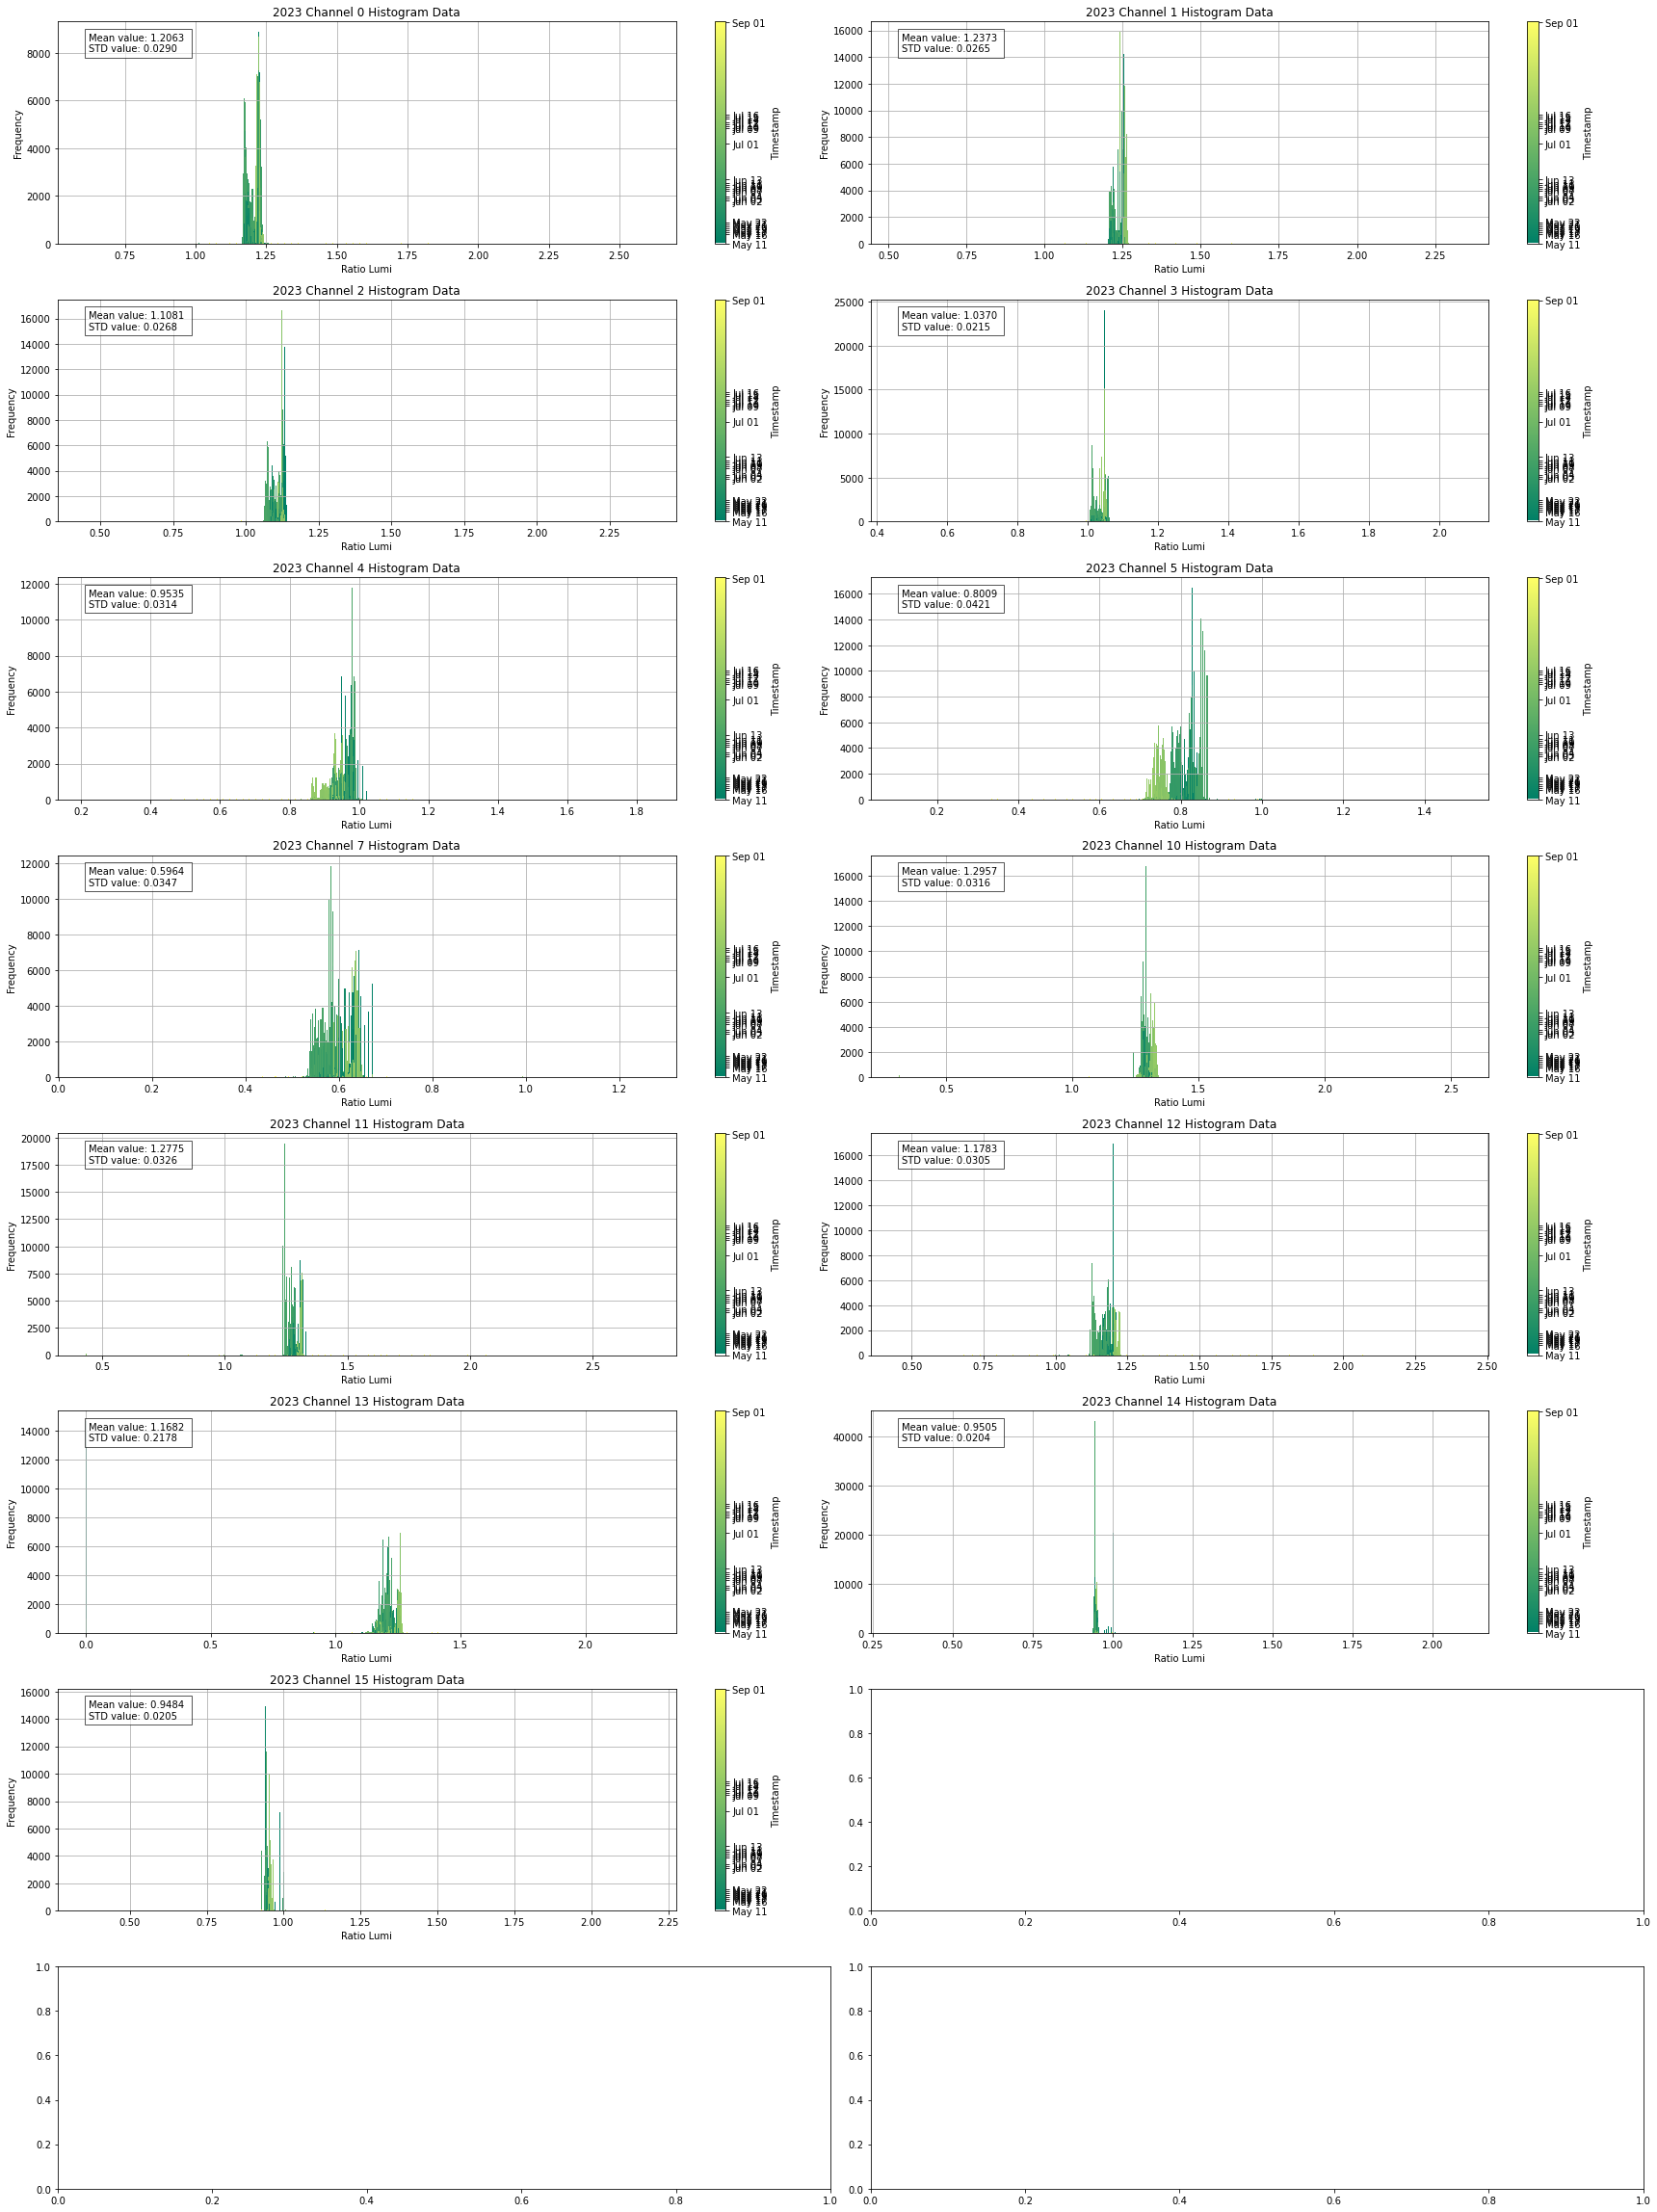

In [8]:
csv_folder = "plt_channel_data"     
csv_files = [os.path.join(csv_folder, f'hist_data_channel_{ch}.csv') for ch in channels_good]
csv_dfs = []
fig, axes = plt.subplots(8, 2, figsize=(24, 32))
axes = axes.flatten()

for i, csv_file in enumerate(csv_files):
    #reading in csv and filtering it to not count bin edges where there are no counts
    read_csv = pd.read_csv(csv_file)
    filtered_csv = read_csv[read_csv['Count'] > 1]
    
    if not filtered_csv.empty:
        #dropping any NaT time values
        filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
        bin_edges = filtered_csv['Bin_Edges']
        counts = filtered_csv['Count']
        
        if counts.sum() == 0:
            print(f"No valid data for fitting Gaussian in channel {channels_good[i]}")
            continue
        
        #finding the mean and std of the distributions
        weighted_sum = (bin_edges * counts).sum()
        total_counts = counts.sum()
        weighted_mean = (weighted_sum / total_counts)
        weighted_variance = (counts * (bin_edges - weighted_mean) ** 2).sum() / total_counts
        weighted_std = np.sqrt(weighted_variance)
        mu_initial = bin_edges.iloc[np.argmax(counts)]
        sigma_initial = np.std(bin_edges)
        min_value = bin_edges.min()
        max_value = bin_edges.max()
        
        #creating colormap to represent date-times
        df_color = pd.DataFrame({'Date-Time': filtered_csv['Date-Time']})
        df_color['Date-Time'] = pd.to_datetime(df_color['Date-Time'])
        df_color['Timestamp'] = df_color['Date-Time'].astype(np.int64) / 10**9 
        norm = plt.Normalize(df_color['Timestamp'].min(), df_color['Timestamp'].max())
        colormap = plt.cm.summer
        df_color['Color'] = df_color['Timestamp'].apply(lambda x: colormap(norm(x)))

        ax = axes[i]
        bin_width = 0.0025
        ax.bar(bin_edges, counts, width=bin_width, align='edge', color=df_color['Color'])

        cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax)
        cbar.set_label('Timestamp')
        
        #creating the date tick marks
        unique_dates = df_color['Date-Time'].dt.date.unique()
        unique_timestamps = [pd.Timestamp(date).timestamp() for date in unique_dates]

        cbar.set_ticks(unique_timestamps)
        cbar.set_ticklabels([pd.to_datetime(ts, unit='s').strftime('%b %d') for ts in unique_timestamps])
         
        ax.set_title(f"2023 Channel {channels_good[i]} Histogram Data")
        ax.set_xlabel("Ratio Lumi")
        ax.set_ylabel("Frequency")
        ax.grid(True)
            
        text_str = f"Mean value: {weighted_mean:.4f} \nSTD value: {weighted_std:.4f}" 
        bbox_props = dict(facecolor='white', alpha=0.65)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

    else:
        print(f"No valid data for fitting Gaussian in channel {channels_good[i]}")
    
plt.tight_layout()
plt.show()

## Plot the stacked histograms, with the added feature of truncating if desired to get a better visualization of the main distribution.

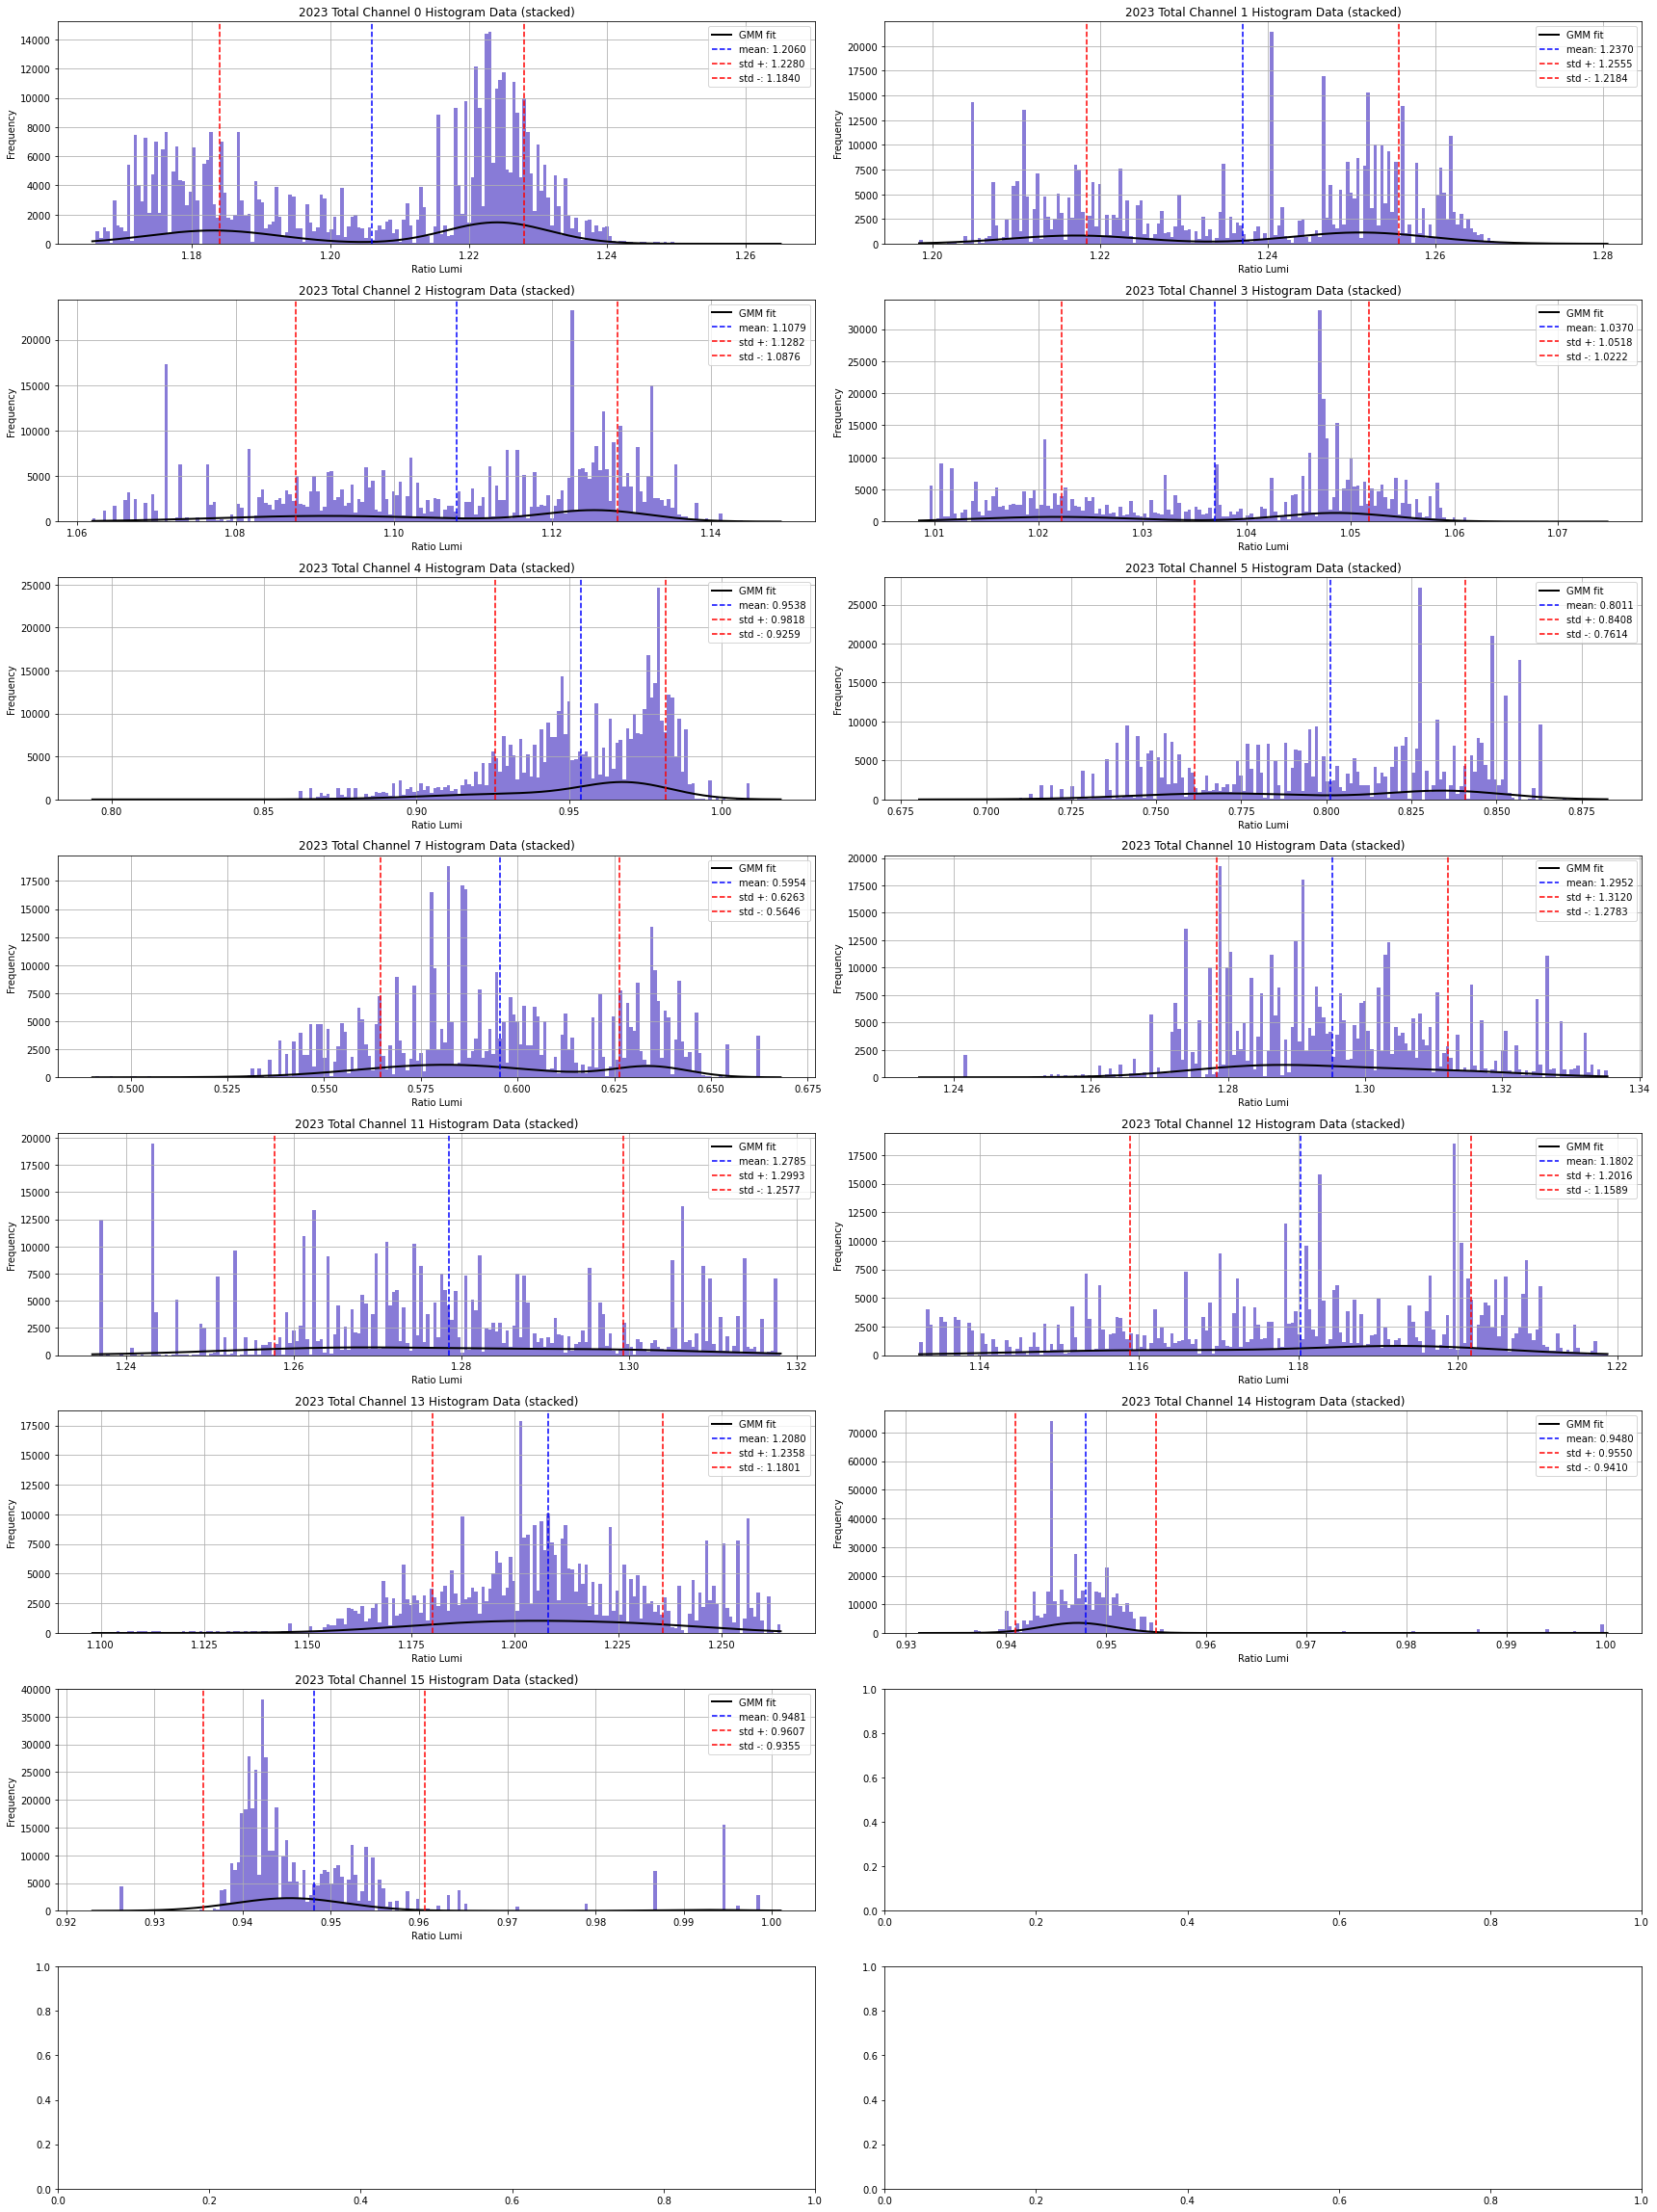

In [9]:
mean_values = []
std_values = []
min_values = []
max_values = []

fig, axes = plt.subplots(8, 2, figsize=(24, 32))
axes = axes.flatten()

for i, csv_file in enumerate(csv_files):
    #reading in the csv and filtering out values not needed
    read_csv = pd.read_csv(csv_file, usecols=['Bin_Edges', 'Count'])
    filtered_csv = read_csv[read_csv['Count'] > 1]
    bin_edges = filtered_csv['Bin_Edges'].values
    counts = filtered_csv['Count'].values

    #creating truncated plots to zoom in further and see distribution better
    bin_vals_large = sorted(bin_edges, reverse=True)[:50]
    bin_vals_small = sorted(bin_edges)[:50]
    bins_to_remove = set(bin_vals_large) | set(bin_vals_small)
    bin_edges_reduced = np.array([value for value in bin_edges if value not in bins_to_remove])
    counts_reduced = np.array([counts[idx] for idx, value in enumerate(bin_edges) if value not in bins_to_remove])

    #calculating truncated mean and std values
    weighted_sum = (bin_edges_reduced * counts_reduced).sum()
    total_counts = counts_reduced.sum()
    weighted_mean = (weighted_sum / total_counts)
    mean_values.append(weighted_mean)
    
    weighted_variance = (counts_reduced * (bin_edges_reduced - weighted_mean) ** 2).sum() / total_counts
    weighted_std = np.sqrt(weighted_variance)
    std_values.append(weighted_std)
    
    max_value = bin_edges_reduced.max() if bin_edges_reduced.size > 0 else float('nan')
    min_value = bin_edges_reduced.min() if bin_edges_reduced.size > 0 else float('nan')
    max_values.append(max_value)
    min_values.append(min_value)
    
    #trying to fit a gaussian mixing matrix since gaussian fit isn't pretty for PLT after lots of fills
    data = np.repeat(bin_edges_reduced[:, np.newaxis], counts_reduced, axis=0) 
    gmm = GaussianMixture(n_components=2, covariance_type='diag')
    gmm.fit(data)

    x = np.linspace(bin_edges_reduced.min(), bin_edges_reduced.max(), 1000).reshape(-1, 1)
    logprob = gmm.score_samples(x)
    pdf = np.exp(logprob)

    ax = axes[i]
    ax.hist(bin_edges_reduced, bins=200, weights=counts_reduced, color='slateblue', alpha=0.8)
    ax.plot(x, pdf * counts_reduced.sum() / pdf.sum(), color='black', lw=2, label='GMM fit')

    ax.axvline(x=weighted_mean, linestyle='--', color='b', label=f'mean: {weighted_mean:.4f}')
    ax.axvline(x=weighted_mean + weighted_std, linestyle='--', color='r', label=f'std +: {(weighted_mean + weighted_std):.4f}')
    ax.axvline(x=weighted_mean - weighted_std, linestyle='--', color='r', label=f'std -: {(weighted_mean - weighted_std):.4f}')

    ax.set_xlabel('Ratio Lumi')
    ax.set_ylabel('Frequency')
    ax.set_title(f"2023 Total Channel {channels_good[i]} Histogram Data (stacked)")
    ax.grid(True)
    ax.legend(loc='best')

plt.tight_layout()
plt.show()

# Visualize the 5 most recent fills compared to the one just loaded in.

The fill numbers for the selected 5 fills nearest fill 8796 shown are: [8804 8816 8784 8811 8794]


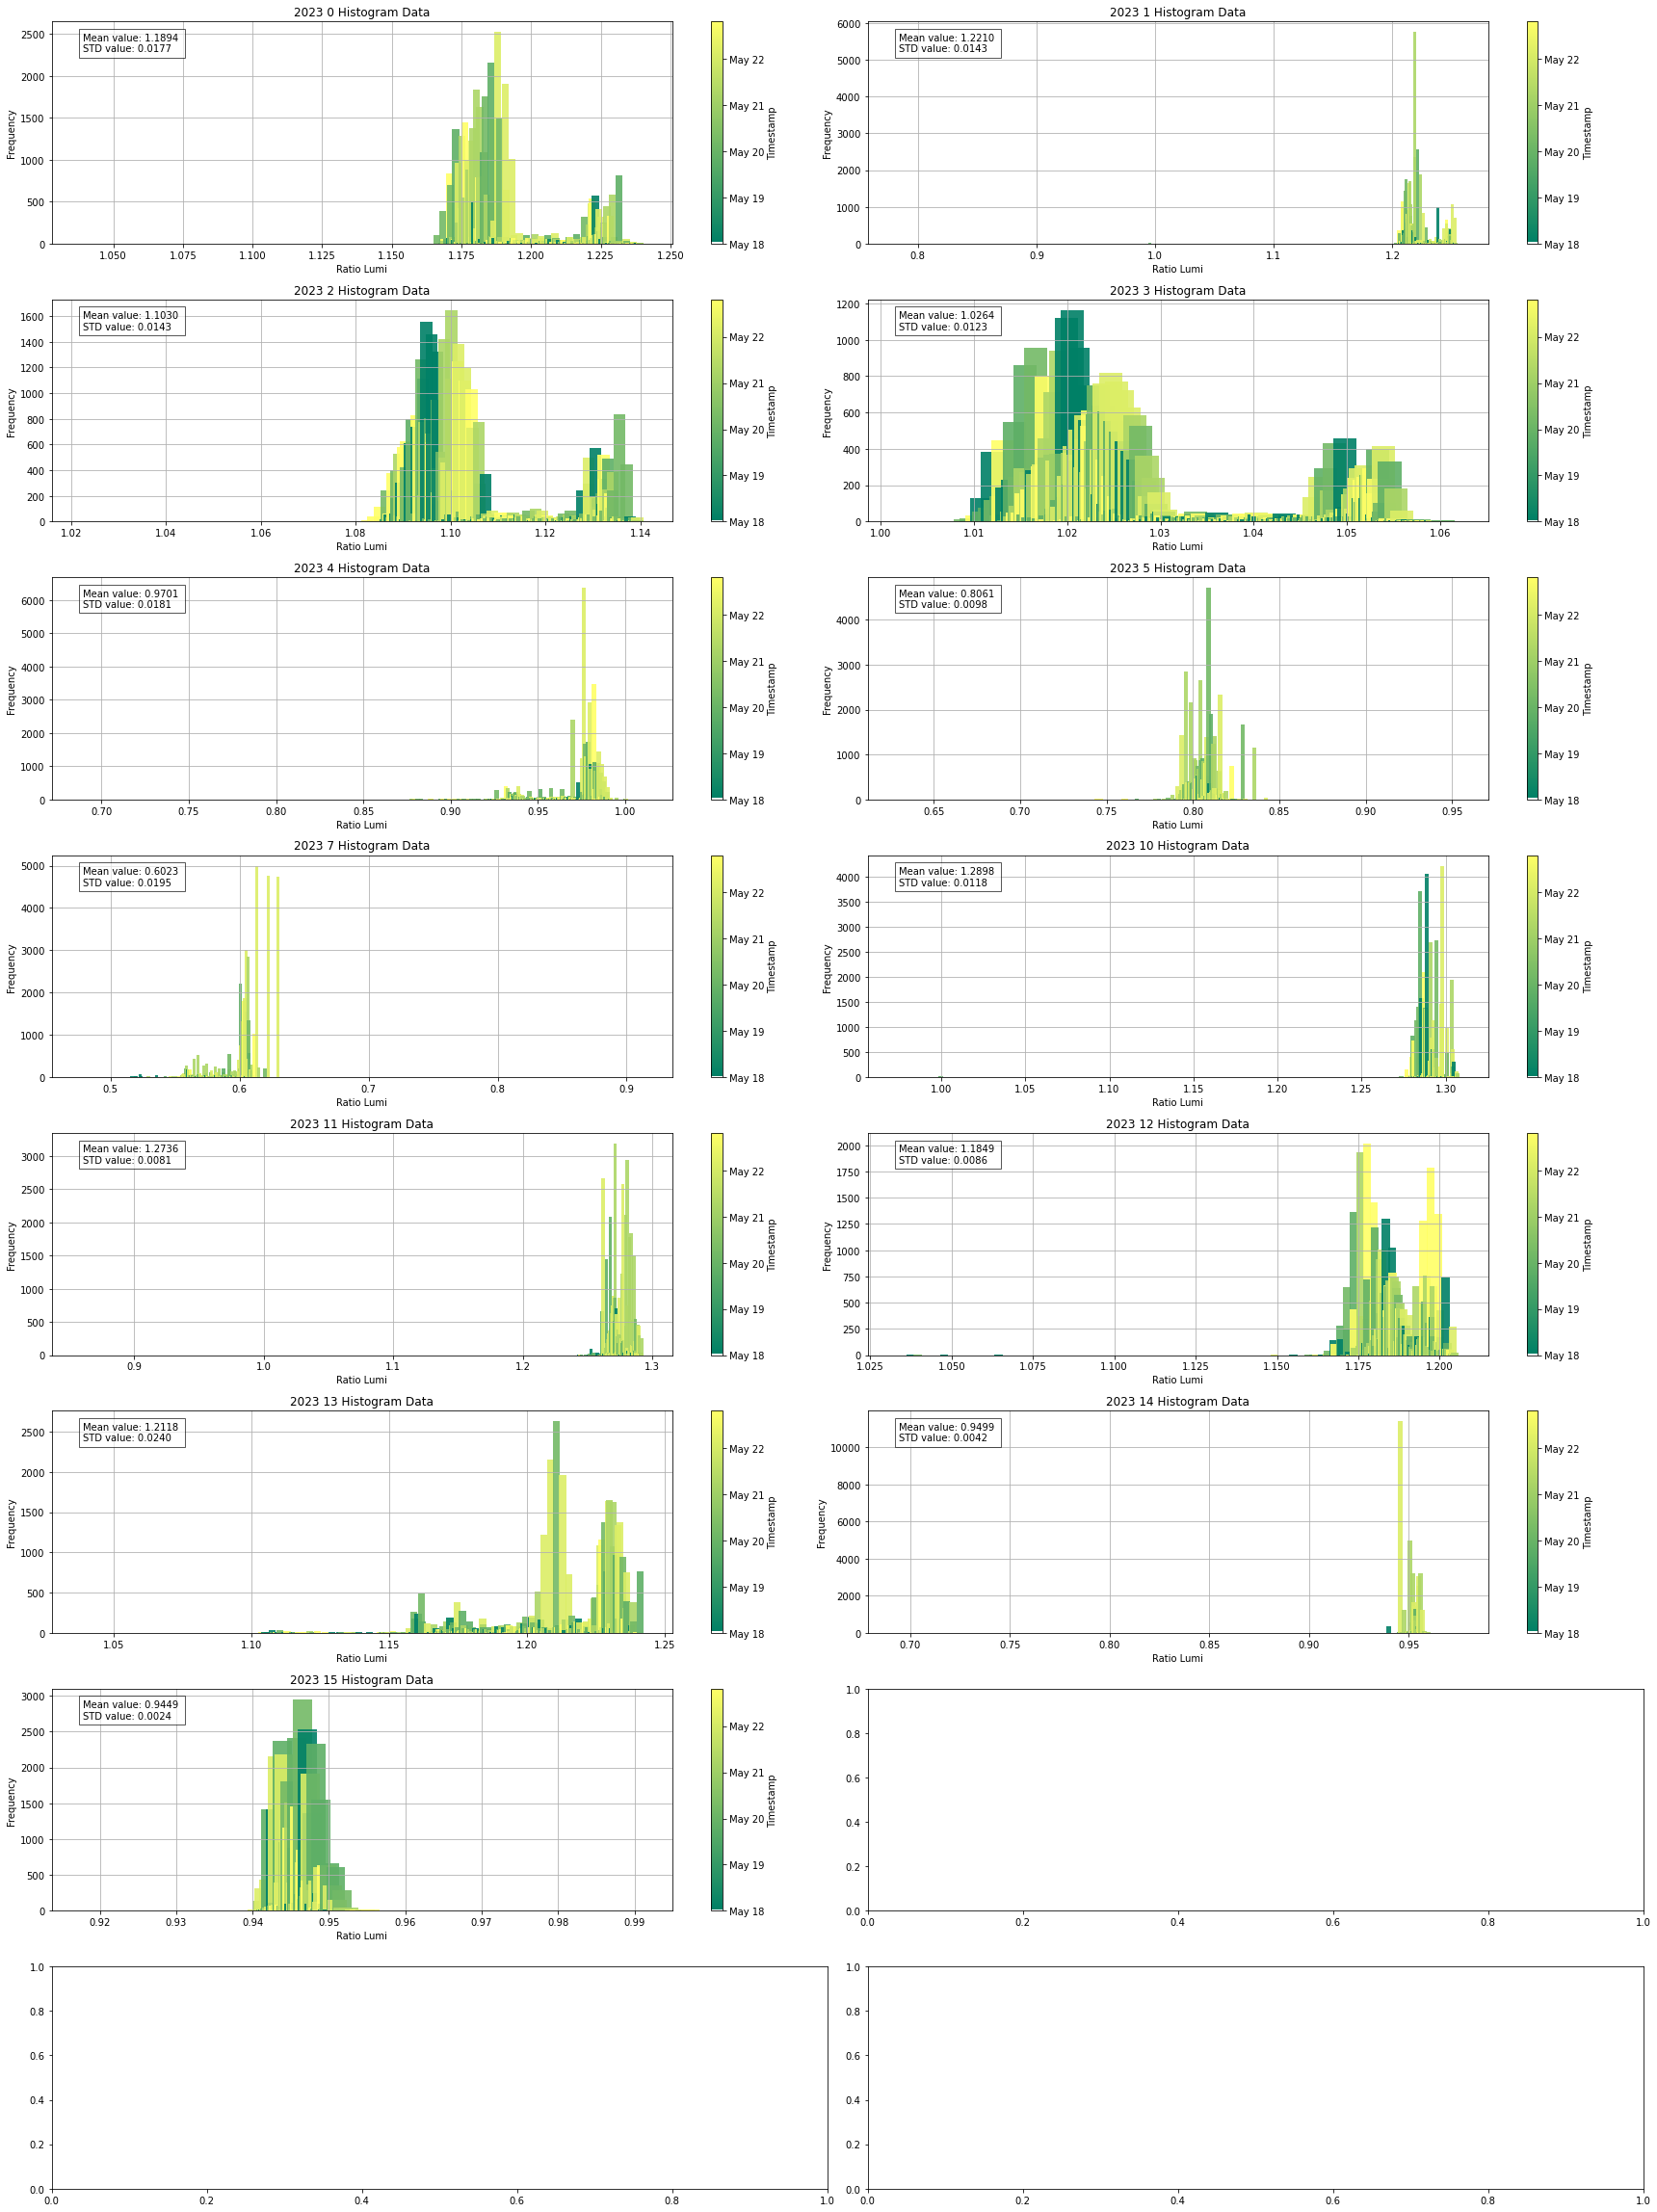

In [30]:
num_fills_desired = 5
csv_dfs = []
for csv_file in csv_files:
    df = pd.read_csv(csv_file)
    csv_dfs.append(df)

def find_closest_fills(dates, target_date, num_fills=num_fills_desired):
    dates = pd.to_datetime(dates, errors='coerce')
    dates = dates.dropna()
    date_diff = [(date, abs(date - target_date)) for date in dates]
    date_diff_sorted = sorted(date_diff, key=lambda x: x[1])
    closest_dates = []
    used_dates = set()
    for date, diff in date_diff_sorted:
        if len(closest_dates) >= num_fills:
            break
        if date not in used_dates:
            closest_dates.append(date)
            used_dates.add(date)
    return closest_dates

def check_date_format(df, i):
    df['Date-Time'] = pd.to_datetime(df['Date-Time'], errors='coerce')
    return df

fig, axes = plt.subplots(8, 2, figsize=(24, 32))
axes = axes.flatten()
fill_numbers_per_channel = {}
for i, (df, channel) in enumerate(zip(csv_dfs, channels_good)):

    df = check_date_format(df, i)
    filtered_df = df[df['Count'] > 1]
  
    if not filtered_df.empty:
        filtered_df = filtered_df.dropna(subset=['Date-Time'])
        current_fill_date = pd.to_datetime(reference_dt.iloc[i])
        
        all_dates = pd.concat([d['Date-Time'] for d in csv_dfs])
        all_dates = pd.to_datetime(all_dates, errors='coerce')
        
        closest_fills = find_closest_fills(all_dates, current_fill_date, num_fills=num_fills_desired + 1)
        closest_fills = [pd.Timestamp(date).tz_convert('UTC') for date in closest_fills]

        try:
            combined_df = pd.concat([
                d[d['Date-Time'].dt.floor('S').isin([fill.floor('S') for fill in closest_fills])]
                for d in [df]
            ])
        except AttributeError as e:
            print(f"Error during filtering: {e}")
            continue
        
        combined_df = combined_df.drop_duplicates()

        # Print fill numbers if available
        if 'Fill_Number' in combined_df.columns:
            fill_numbers = combined_df['Fill_Number'].unique()
            # Exclude the current fill number from the fill numbers
            fill_numbers = fill_numbers[fill_numbers != fill_number]
            
            fill_numbers_per_channel[channel] = fill_numbers
        else:
            continue

        if combined_df['Count'].sum() == 0:
            print(f"No valid data for fitting Gaussian in channel {channel}")
        else:
            bin_edges = combined_df['Bin_Edges']
            counts = combined_df['Count']

            # Filter extreme bins
            bin_edges = pd.Series(bin_edges)
            counts = pd.Series(counts)
            
            #truncating to make it easier to visualize, can remove if wanted
            bin_vals_large = sorted(bin_edges.unique(), reverse=True)[:50]
            bin_vals_small = sorted(bin_edges.unique())[:50]
            bins_to_remove = set(bin_vals_large) | set(bin_vals_small)
            
            filtered_indices = ~bin_edges.isin(bins_to_remove)
            filtered_bin_edges = bin_edges[filtered_indices]
            filtered_counts = counts[filtered_indices]
            
            filtered_bin_edges = filtered_bin_edges.to_numpy()
            filtered_counts = filtered_counts.to_numpy()

            if len(filtered_bin_edges) == 0:
                print(f"No valid data after filtering in channel {channel}")
                continue

            weighted_sum = (filtered_bin_edges * filtered_counts).sum()
            total_counts = filtered_counts.sum()
            weighted_mean = (weighted_sum / total_counts)
            weighted_variance = (filtered_counts * (filtered_bin_edges - weighted_mean) ** 2).sum() / total_counts
            weighted_std = np.sqrt(weighted_variance)

            df_color = pd.DataFrame({'Date-Time': combined_df['Date-Time']})
            df_color['Date-Time'] = pd.to_datetime(df_color['Date-Time'])
            df_color['Timestamp'] = df_color['Date-Time'].astype(np.int64) / 10**9 
            norm = plt.Normalize(df_color['Timestamp'].min(), df_color['Timestamp'].max())
            colormap = plt.cm.summer
            df_color['Color'] = df_color['Timestamp'].apply(lambda x: colormap(norm(x)))

            ax = axes[i]
            bin_width = 0.0025
            ax.bar(filtered_bin_edges, filtered_counts, width=bin_width, align='edge', color=df_color['Color'].iloc[:len(filtered_bin_edges)], alpha = 0.9)

            cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=colormap), ax=ax)
            cbar.set_label('Timestamp')
    
            unique_dates = df_color['Date-Time'].dt.date.unique()
            unique_timestamps = [pd.Timestamp(date).timestamp() for date in unique_dates]

            cbar.set_ticks(unique_timestamps)
            cbar.set_ticklabels([pd.to_datetime(ts, unit='s').strftime('%b %d') for ts in unique_timestamps])
     
            ax.set_title(f"2023 {channel} Histogram Data")
            ax.set_xlabel("Ratio Lumi")
            ax.set_ylabel("Frequency")
            ax.grid(True)
        
            text_str = f"Mean value: {weighted_mean:.4f} \nSTD value: {weighted_std:.4f}" 
            if 'fill_number' in combined_df.columns:
                fill_number = combined_df['fill_number'].unique()
                text_str += f" \nFill Number: {', '.join(map(str, fill_number))}"
            bbox_props = dict(facecolor='white', alpha=0.65)
            ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

            
print(f"The fill numbers for the selected {num_fills_desired} fills nearest fill {fill_number} shown are: {fill_numbers}")
plt.tight_layout()
plt.show()

# Table Displaying Information Pertaining to PLT Channel Distributions for 2023

In [31]:
spread_values = [max_values[ch] - min_values[ch] for ch in range(len(max_values))]
mean_values_df = pd.DataFrame(mean_values, columns=['Mean'])
std_values_df = pd.DataFrame(std_values, columns=['Std'])
spread_values_df = pd.DataFrame(spread_values, columns=['Spread'])

#concatinating the mean and std and spread values together to create a df
mean_std = pd.concat([mean_values_df, std_values_df, spread_values_df], axis=1)
mean_std.index = channels_good
mean_std = mean_std.sort_index()

#finding the +- 1 sigma values
mean_std['Std Low'] = mean_std['Mean'] - mean_std['Std']
mean_std['Std High'] = mean_std['Mean'] + mean_std['Std']

outside_up = []
outside_down = []
percent_error = []
outside_sigma = []

for i, csv_file in enumerate(csv_files):
    read_csv = pd.read_csv(csv_file, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    filtered_csv = read_csv[(read_csv['Count'] > 1) & read_csv['Date-Time'].notna()]

    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    mean = mean_std.iloc[i]['Mean']
    std = mean_std.iloc[i]['Std']
    
    lower_bound = mean - std
    upper_bound = mean + std
    inside_bounds = (bin_edges >= lower_bound) & (bin_edges <= upper_bound)
    outside_upper = bin_edges > upper_bound
    outside_lower = bin_edges < lower_bound

    #finding the total counts that lie above 1 sigma and below 1 sigma to then find the percentage of points that reside outside +- 1 sigma and seeing if this matches/is greater/is less than expected 32%
    counts_inside_sigma = counts[inside_bounds].sum()
    counts_outside_sigma = counts[outside_upper | outside_lower].sum()
    total_counts = counts.sum()

    outside_up.append(counts[outside_upper].sum())
    outside_down.append(counts[outside_lower].sum())

    percentage = 100 * (counts_outside_sigma / total_counts)
    percent_error.append(percentage)
    
    outside_sigma_value = 100 - percentage
    if outside_sigma_value > 68:
        outside_sigma.append('Yes')
    else:
        outside_sigma.append('No')

#adding info to table
mean_std['Points Above 1 Sigma'] = outside_up
mean_std['Points Below 1 Sigma'] = outside_down
mean_std['Percent Error'] = percent_error
mean_std['Meets 1 Sigma Expectation'] = outside_sigma
    

#visualize the table
html_std = mean_std.to_html(classes='table table-striped', index=True)

html_output = f"""
<div style="width: 80%; margin: 20px auto;">
    <h3 style="text-alicgn: center;">PLT Channel Histogram Data (truncated)</h3>
    {html_std}
</div>

<style>
    .table {{
        width: 100%;
        border-collapse: collapse;
        margin: 0 auto;
    }}
    .table th, .table td {{
        border: 1px solid #ddd;
        padding: 8px;
        text-align: left;
    }}
    .table th {{
        background-color: #f2f2f2;
        font-weight: bold;
    }}
    .table-striped tbody tr:nth-of-type(odd) {{
        background-color: #f9f9f9;
    }}
</style>
"""

display(HTML(html_output))

,Mean,Std,Spread,Std Low,Std High,Points Above 1 Sigma,Points Below 1 Sigma,Percent Error,Meets 1 Sigma Expectation
0,1.206005,0.022001,0.099378,1.184004,1.228006,68231,128258,40.190101,No
1,1.236974,0.018575,0.082072,1.218399,1.255549,84810,119969,41.883948,No
2,1.107875,0.020301,0.086902,1.087573,1.128176,86577,94595,37.052747,No
3,1.036992,0.014792,0.066256,1.022200,1.051784,72578,123076,40.007116,No
4,0.953811,0.027954,0.225678,0.925857,0.981766,59834,70306,26.634140,Yes
5,0.801124,0.039704,0.202342,0.761420,0.840828,106145,112757,44.800874,No
7,0.595441,0.030815,0.177896,0.564626,0.626256,122052,84340,42.229752,No
10,1.295184,0.016855,0.100395,1.278329,1.312039,88079,70424,32.405882,No
11,1.278466,0.020793,0.082123,1.257674,1.299259,96179,84794,37.009172,No
12,1.180225,0.021359,0.086319,1.158866,1.201584,94841,116781,43.274447,No


# Visualizing all PLT Channel Distributions Against One Another

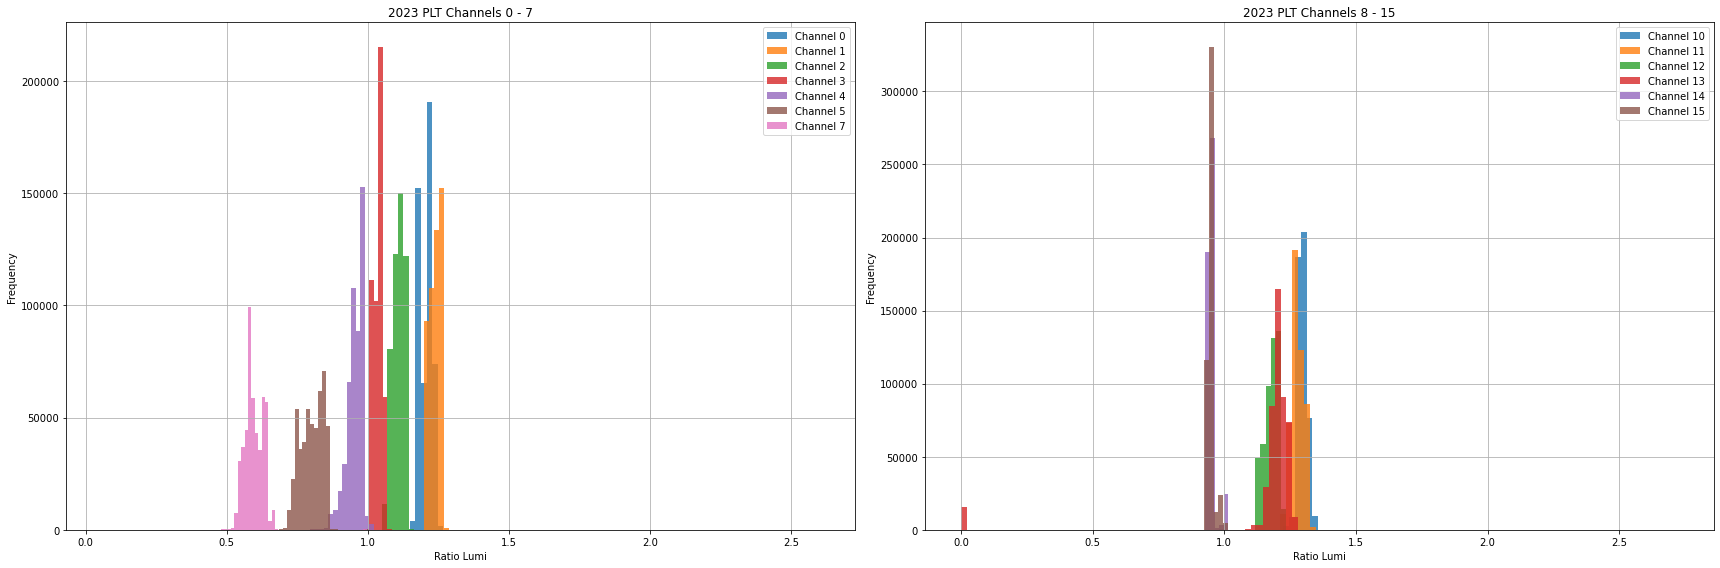

In [12]:
first_half = [0, 1, 2, 3, 4, 5, 6, 7]
second_half = [8, 9, 10, 11, 12, 13, 14, 15]
fig, axes = plt.subplots(1, 2, figsize=(24, 8))

for i, csv_file in enumerate(csv_files):
    channel_number = int(os.path.basename(csv_file).split('_')[-1].split('.')[0])
    if channel_number in channels_failed:
        continue
    read_csv = pd.read_csv(csv_file)
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    bin_width = 0.005
    
    if channel_number in first_half:
        #plotting channels 0-7
        axes[0].hist(bin_edges, bins=100, weights=counts, alpha = 0.8, label=f'Channel {channel_number}')
    elif channel_number in second_half:
        #plotting channels 8-15
        axes[1].hist(bin_edges, bins=100, weights=counts, alpha = 0.8, label=f'Channel {channel_number}')

axes[0].set_title("2023 PLT Channels 0 - 7")
axes[0].set_xlabel("Ratio Lumi")
axes[0].set_ylabel("Frequency")
axes[0].grid(True)
axes[0].legend(loc='best')

axes[1].set_title("2023 PLT Channels 8 - 15")
axes[1].set_xlabel("Ratio Lumi")
axes[1].set_ylabel("Frequency")
axes[1].grid(True)
axes[1].legend(loc='best')

plt.tight_layout()
plt.show()

# Visualizing PLT Channel Distributions Against BCM1F and HF

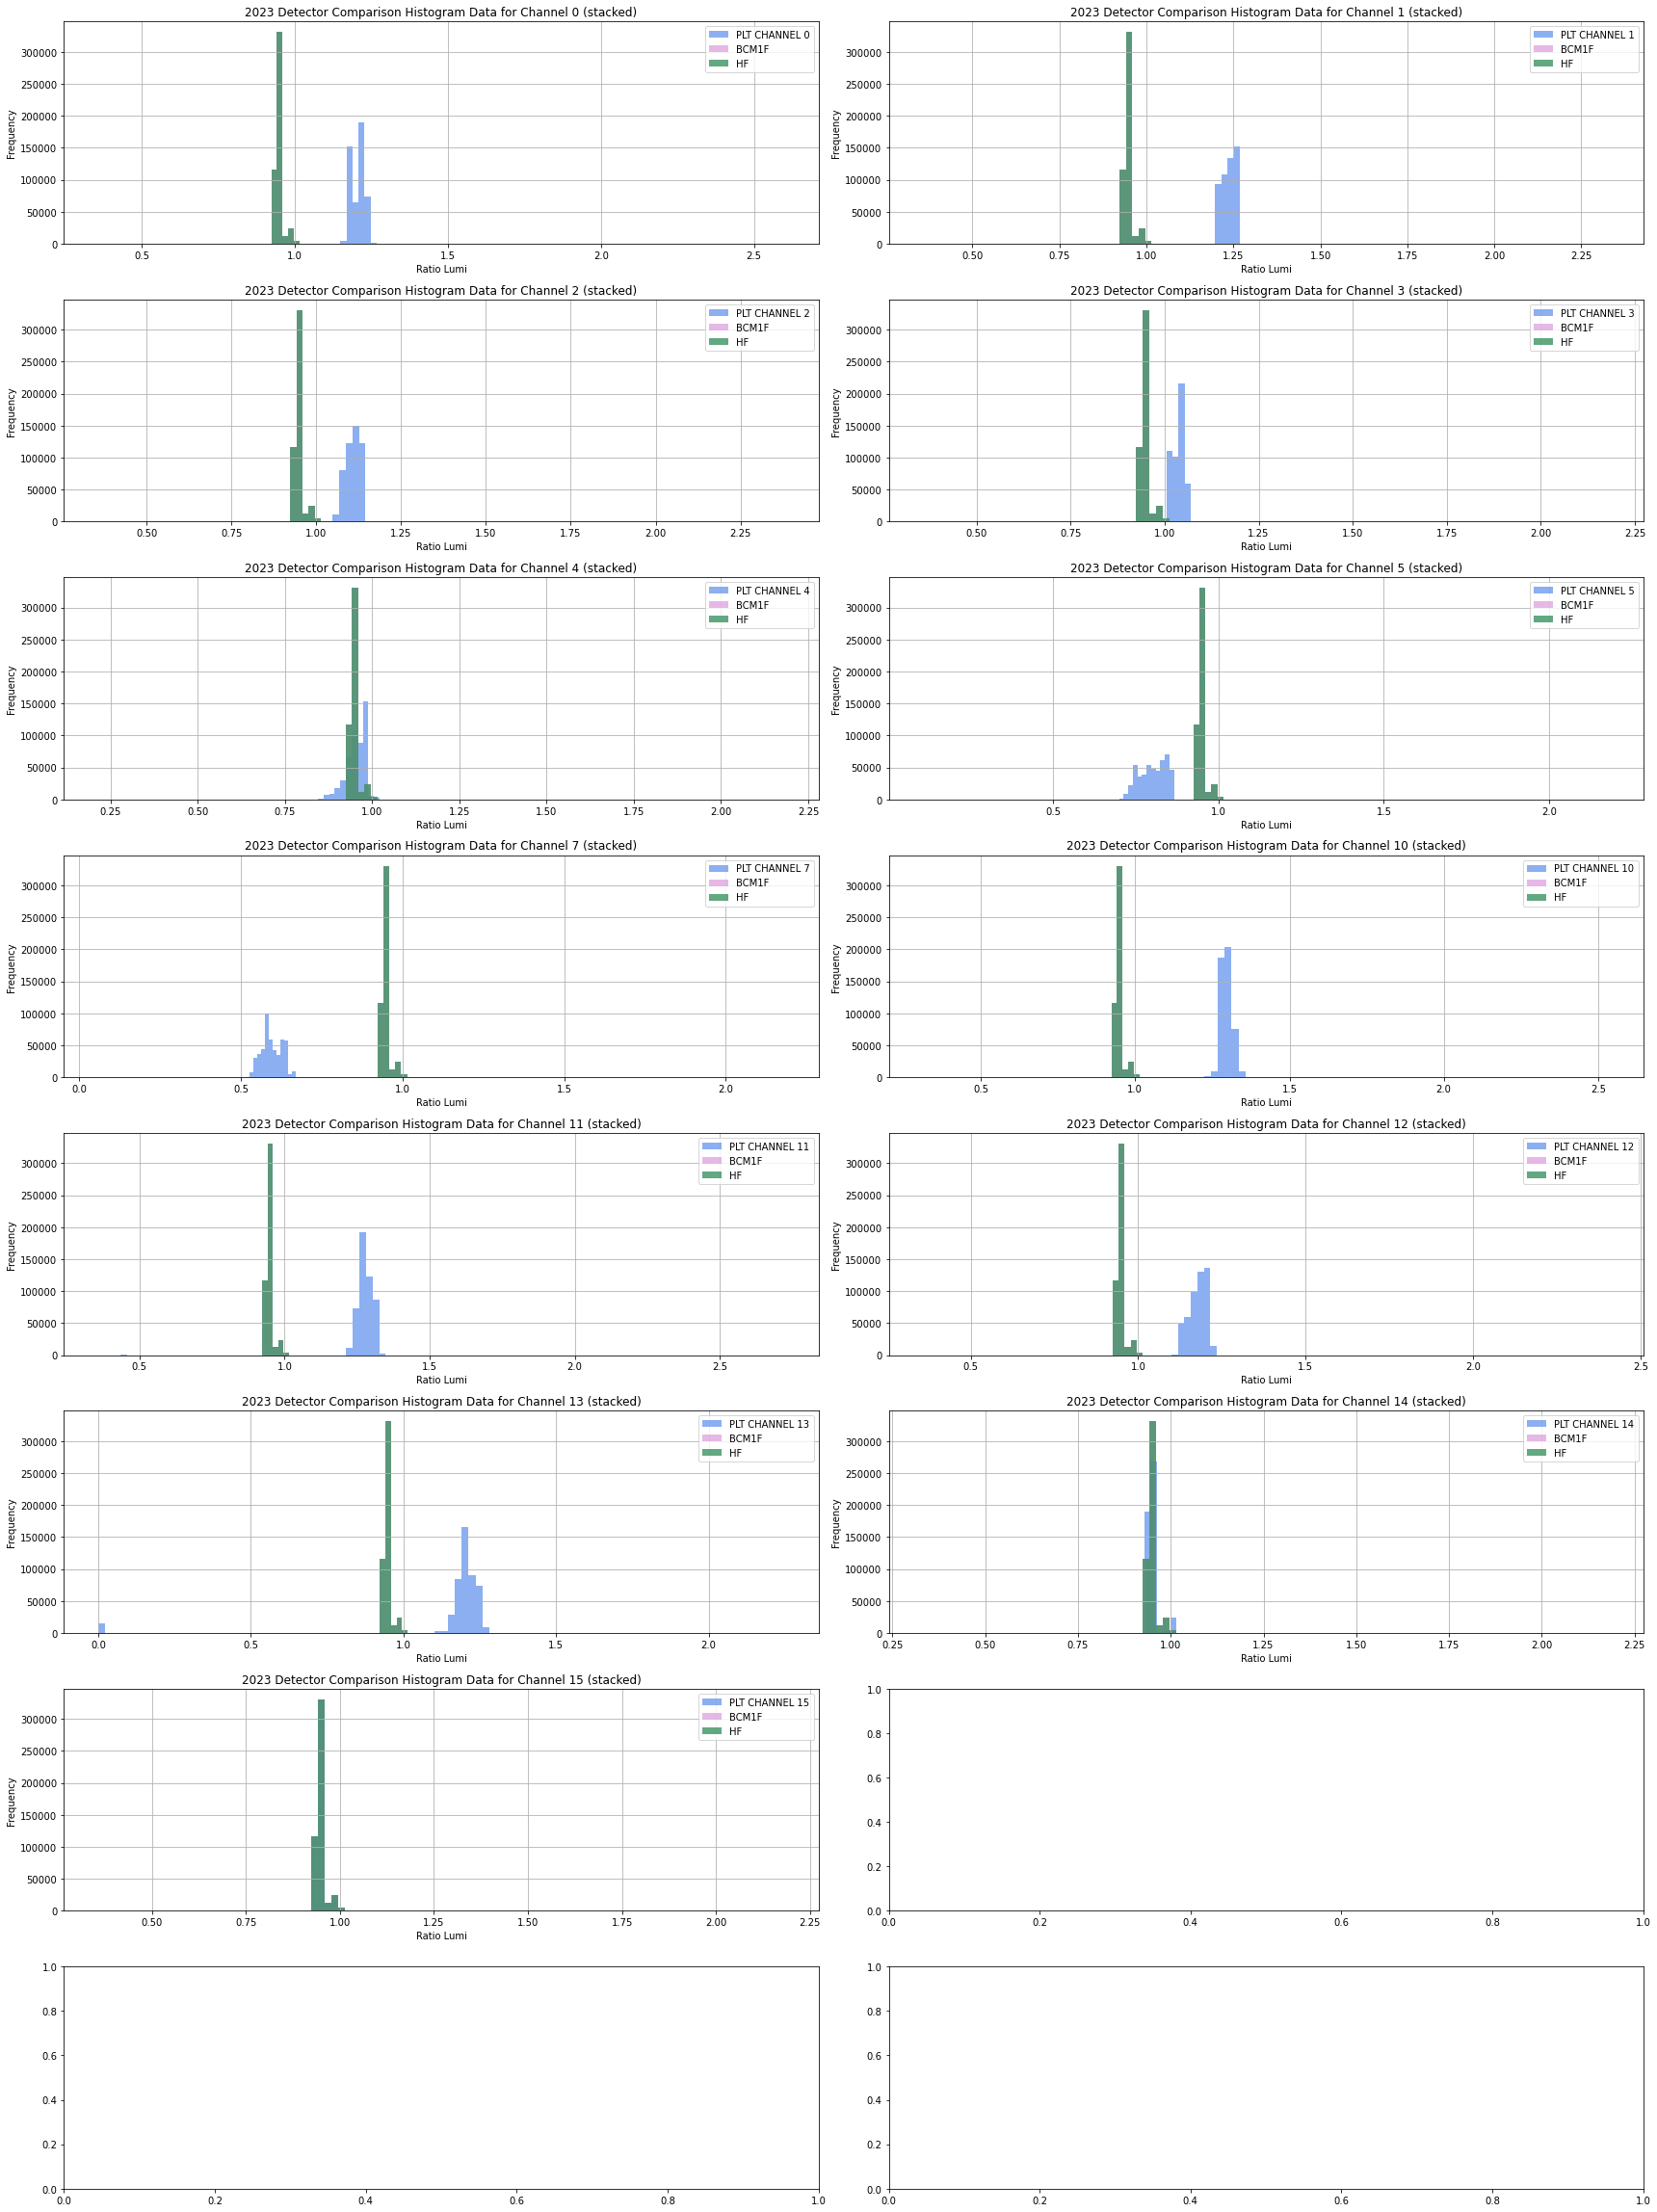

In [13]:
hf_csv = 'hf_data.csv'
bcm1f_csv = 'bcm1f_data.csv'

fig, axes = plt.subplots(8, 2, figsize=(24, 32))
axes = axes.flatten()

for i, csv_file in enumerate(csv_files):
    read_csv = pd.read_csv(csv_file, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    read_bcm1f = pd.read_csv(bcm1f_csv, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    read_hf = pd.read_csv(hf_csv, usecols=['Bin_Edges', 'Count', 'Date-Time'])
    
    filtered_csv = read_csv[read_csv['Count'] > 1]
    filtered_csv = filtered_csv.dropna(subset=['Date-Time'])
    bin_edges = filtered_csv['Bin_Edges']
    counts = filtered_csv['Count']
    
    filtered_csv_bcm1f = read_bcm1f[read_bcm1f['Count'] > 1]
    filtered_csv_bcm1f = filtered_csv_bcm1f.dropna(subset=['Date-Time'])
    bin_edges_bcm1f = filtered_csv_bcm1f['Bin_Edges']
    counts_bcm1f = filtered_csv_bcm1f['Count']
    
    filtered_csv_hf = read_hf[read_hf['Count'] > 1]
    filtered_csv_hf = filtered_csv_hf.dropna(subset=['Date-Time'])
    bin_edges_hf = filtered_csv_hf['Bin_Edges']
    counts_hf = filtered_csv_hf['Count']

    ax = axes[i]
    ax.hist(bin_edges, bins=100, weights=counts, color='cornflowerblue', alpha = 0.75, label = f'PLT CHANNEL {channels_good[i]}')  
    ax.hist(bin_edges_bcm1f, bins=100, weights=counts_bcm1f, color='plum', alpha = 0.75, label = f'BCM1F')  
    ax.hist(bin_edges_hf, bins=100, weights=counts_hf, color='seagreen', alpha = 0.75, label = f'HF')  
    ax.set_xlabel('Ratio Lumi')
    ax.set_ylabel('Frequency')
    ax.set_title(f"2023 Detector Comparison Histogram Data for Channel {channels_good[i]} (stacked)")
    ax.grid(True)
    ax.legend(loc = 'best')

plt.tight_layout()
plt.show()

# Plot histogram distribution of BCM1F/ HF ratios.

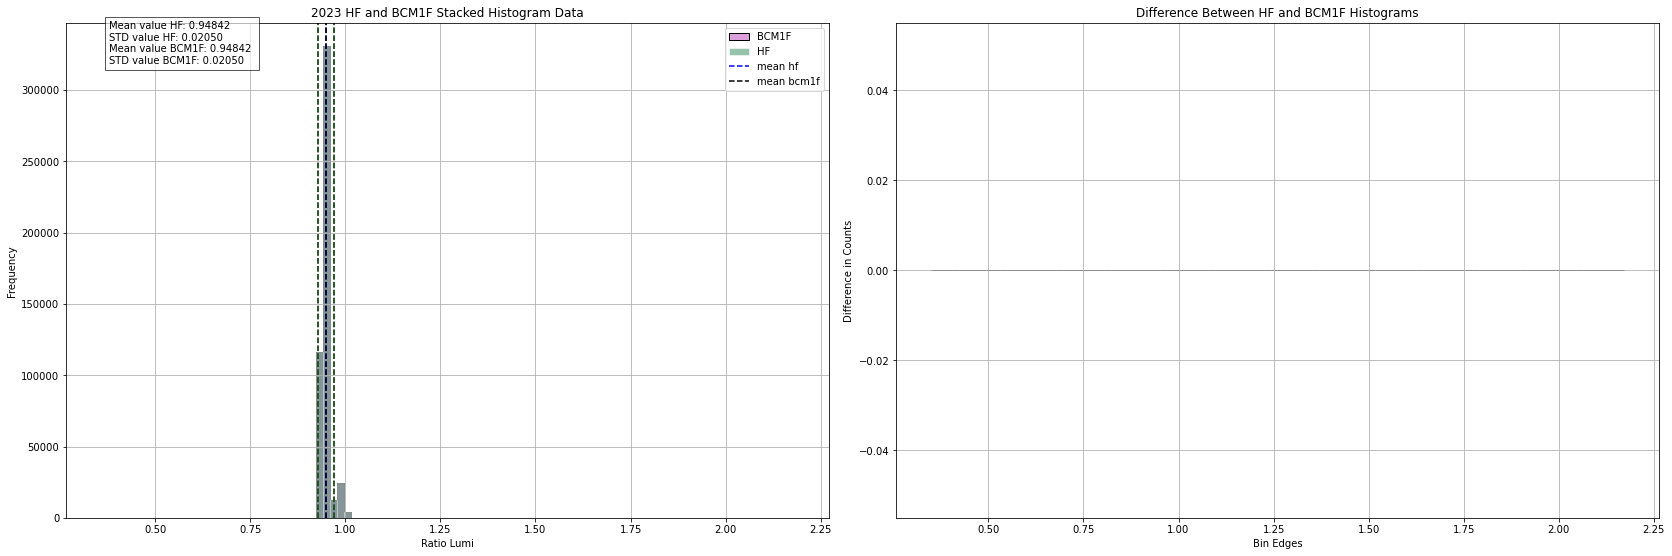

In [14]:
mean_hf = []
std_hf = []
mean_bcm1f = []
std_bcm1f = []

read_bcm1f = pd.read_csv(bcm1f_csv, usecols=['Bin_Edges', 'Count', 'Date-Time'])
read_hf = pd.read_csv(hf_csv, usecols=['Bin_Edges', 'Count', 'Date-Time'])

filtered_csv_bcm1f = read_bcm1f[read_bcm1f['Count'] > 1]
filtered_csv_bcm1f = filtered_csv_bcm1f.dropna(subset=['Date-Time'])
bin_edges_bcm1f = filtered_csv_bcm1f['Bin_Edges']
counts_bcm1f = filtered_csv_bcm1f['Count']

filtered_csv_hf = read_hf[read_hf['Count'] > 1]
filtered_csv_hf = filtered_csv_hf.dropna(subset=['Date-Time'])
bin_edges_hf = filtered_csv_hf['Bin_Edges']
counts_hf = filtered_csv_hf['Count']

bin_number = 100
bins = np.histogram_bin_edges(np.concatenate([bin_edges_bcm1f, bin_edges_hf]), bins=bin_number)

counts_bcm1f_hist, _ = np.histogram(bin_edges_bcm1f, bins=bins, weights=counts_bcm1f)
counts_hf_hist, _ = np.histogram(bin_edges_hf, bins=bins, weights=counts_hf)
difference_counts = counts_hf_hist - counts_bcm1f_hist


weighted_sum_hf = (bin_edges_hf * counts_hf).sum()
total_counts_hf = counts_hf.sum()
weighted_mean_hf = (weighted_sum_hf / total_counts_hf)
mean_hf.append(weighted_mean)
weighted_variance_hf = (counts_hf * (bin_edges_hf - weighted_mean_hf) ** 2).sum() / total_counts_hf
weighted_std_hf = np.sqrt(weighted_variance_hf)
std_hf.append(weighted_std_hf)

weighted_sum_bcm1f = (bin_edges_bcm1f * counts_bcm1f).sum()
total_counts_bcm1f = counts_bcm1f.sum()
weighted_mean_bcm1f = (weighted_sum_bcm1f / total_counts_bcm1f)
mean_bcm1f.append(weighted_mean_bcm1f)
weighted_variance_bcm1f = (counts_bcm1f * (bin_edges_bcm1f - weighted_mean_bcm1f) ** 2).sum() / total_counts_bcm1f
weighted_std_bcm1f = np.sqrt(weighted_variance_bcm1f)
std_bcm1f.append(weighted_std_bcm1f)


fig, axes = plt.subplots(1, 2, figsize=(24, 8))

axes[0].hist(bin_edges_bcm1f, bins=bin_number, weights=counts_bcm1f, color='plum', edgecolor='black', label = f'BCM1F', alpha = 1)  
axes[0].hist(bin_edges_hf, bins=bin_number, weights=counts_hf, color='seagreen', edgecolor='white', label = f'HF', alpha = 0.5)
axes[0].axvline(x=weighted_mean_hf, linestyle='--', color='b', label='mean hf')
axes[0].axvline(x=weighted_mean_hf + weighted_std_hf, linestyle = '--', color = 'darkmagenta')
axes[0].axvline(x=weighted_mean_hf - weighted_std_hf, linestyle = '--', color = 'darkmagenta')

axes[0].axvline(x=weighted_mean_bcm1f, linestyle='--', color='black', label='mean bcm1f')
axes[0].axvline(x=weighted_mean_bcm1f + weighted_std_bcm1f, linestyle = '--', color = 'darkgreen')
axes[0].axvline(x=weighted_mean_bcm1f - weighted_std_bcm1f, linestyle = '--', color = 'darkgreen')

axes[0].set_xlabel('Ratio Lumi')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f"2023 HF and BCM1F Stacked Histogram Data")
axes[0].grid(True)
axes[0].legend(loc = 'best')

axes[1].bar(bins[:-1], difference_counts, width=np.diff(bins), color='grey', edgecolor='black')

axes[1].set_xlabel('Bin Edges')
axes[1].set_ylabel('Difference in Counts')
axes[1].set_title('Difference Between HF and BCM1F Histograms')
axes[1].grid(True)

text_str = f"Mean value HF: {weighted_mean_hf:.5f} \nSTD value HF: {weighted_std_hf:.5f} \nMean value BCM1F: {weighted_mean_bcm1f:.5f} \nSTD value BCM1F: {weighted_std_bcm1f:.5f}"
bbox_props = dict(facecolor='white', alpha=0.65)
axes[0].text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=10, verticalalignment='top', bbox=bbox_props)

plt.tight_layout()